## **Imports and notebook configs**


In [1]:
'''Imports'''

import pandas as pd
import numpy as np
import seaborn as sns
import matplotlib
import matplotlib.pyplot as plt
import warnings
from scipy.stats import skew
from scipy import stats
from scipy.stats import norm
import xgboost as xgb
from sklearn.linear_model import LinearRegression, Lasso, Ridge
from sklearn.metrics import mean_squared_error as MSE
from sklearn.ensemble import RandomForestRegressor, GradientBoostingRegressor
warnings.filterwarnings('ignore')
sns.set(style='white', context='notebook', palette='deep')
%config InlineBackend.figure_format = 'retina' #set 'png' here when working on notebook
%matplotlib inline



## Dataset Observation and Properties

In [2]:
'''load datasets'''

train_df = pd.read_csv('Datasets/SE_rents2018_train.csv')
test_df = pd.read_csv('Datasets/SE_rents2018_test1.csv')


In [3]:
train_df.head()

,rental_id,addr_unit,building_id,bedrooms,bathrooms,size_sqft,created_at,addr_street,addr_city,addr_zip,...,has_garden,has_childrens_playroom,rent,no_fee,description,neighborhood,borough,unit,floornumber,line
0,7236931,#22A,551248,4,3.0,1300.0,2018-06-04 16:31:06,645 OCEAN AVENUE,Brooklyn,11226,...,0,0,3925,1,MAGNIFICENT GUT RENOVATED 4 BEDROOM 3 BATHROOM...,Flatbush,Brooklyn,22A,NaN,NaN
1,7331920,#406,3373,0,1.0,475.0,2018-07-03 20:11:43,93 WORTH STREET,New York,10013,...,0,0,3350,0,Want to live in the hottest neighborhood in to...,Tribeca,Manhattan,406,4.0,06
2,7139224,#18A,70747,3,3.0,1886.0,2018-05-02 16:10:27,305 EAST 51 STREET,New York,10022,...,1,0,11500,0,"High floor totally renovated 3 bedrooms, 3 bat...",Midtown East,Manhattan,18A,18.0,A
3,7364827,#23E,42076,1,1.0,827.0,2018-07-13 16:06:55,70 WEST 37TH STREET,New York,10018,...,0,0,3772,1,**SHORT TERM LEASES AVAILABLE**\n\n****Photogr...,Midtown South,Manhattan,23E,23.0,E
4,7242151,#3B,319156,3,1.0,1200.0,2018-06-05 16:35:40,43 MAC DONOUGH STREET,Brooklyn,11216,...,0,0,2595,1,This is a Huuge 3 bedroom apt. located in a pr...,Bedford-Stuyvesant,Brooklyn,3B,3.0,B


In [4]:
test_df.head()

,rental_id,addr_unit,building_id,bedrooms,bathrooms,size_sqft,created_at,addr_street,addr_city,addr_zip,...,has_garden,has_childrens_playroom,rent,no_fee,description,neighborhood,borough,unit,floornumber,line
0,7499437,#1B,18724,1,1.0,550.0,2018-08-22 10:00:37,167 MOTT STREET,New York,10013,...,0,0,2700,1,"By Owner, No Fees!\n\nNewly renovated building...",Little Italy,Manhattan,1B,1.0,B
1,7477903,#C4,403900,1,1.0,750.0,2018-08-15 11:41:23,107 LINDEN STREET,Brooklyn,11221,...,0,0,1650,1,this is a beautiful spacious renovated full s...,Bushwick,Brooklyn,C4,4.0,C
2,7481023,#GARDEN,18175264,2,1.0,800.0,2018-08-15 22:20:14,47 CARROLL STREET,Brooklyn,11231,...,1,0,2900,0,"Garden level, pet-friendly, 2 bedroom, 1 bath ...",Columbia St Waterfront District,Brooklyn,GARDEN,NaN,NaN
3,7479547,#2C,104863,2,2.0,1300.0,2018-08-15 16:05:22,952 COLUMBUS AVENUE,New York,10025,...,0,0,4750,1,Ivy Park is a boutique condominium with a uniq...,Upper West Side,Manhattan,2C,2.0,C
4,7518814,#9,95125,2,1.0,750.0,2018-08-29 12:00:12,424 EAST 116 STREET,New York,10029,...,0,0,1800,0,Located across from the New East River Plaza w...,East Harlem,Manhattan,9,NaN,NaN


In [5]:
print(f"Train Data Columns:{list(train_df)}\n")
print(f"Test Data Columns:{list(test_df)}\n")

Train Data Columns:['rental_id', 'addr_unit', 'building_id', 'bedrooms', 'bathrooms', 'size_sqft', 'created_at', 'addr_street', 'addr_city', 'addr_zip', 'addr_lat', 'addr_lon', 'bin', 'bbl', 'floor_count', 'year_built', 'min_to_subway', 'has_doorman', 'has_elevator', 'has_fireplace', 'has_dishwasher', 'is_furnished', 'has_gym', 'allows_pets', 'has_washer_dryer', 'has_garage', 'has_roofdeck', 'has_concierge', 'has_pool', 'has_garden', 'has_childrens_playroom', 'rent', 'no_fee', 'description', 'neighborhood', 'borough', 'unit', 'floornumber', 'line']

Test Data Columns:['rental_id', 'addr_unit', 'building_id', 'bedrooms', 'bathrooms', 'size_sqft', 'created_at', 'addr_street', 'addr_city', 'addr_zip', 'addr_lat', 'addr_lon', 'bin', 'bbl', 'floor_count', 'year_built', 'min_to_subway', 'has_doorman', 'has_elevator', 'has_fireplace', 'has_dishwasher', 'is_furnished', 'has_gym', 'allows_pets', 'has_washer_dryer', 'has_garage', 'has_roofdeck', 'has_concierge', 'has_pool', 'has_garden', 'has_ch

## Data Cleaning

- Method: Dropping unecessary columns from datasets and save id information

In [6]:
print(f"Train Data Shape Before Drop:{train_df.shape}")
print(f"Test Data Shape Before Drop:{test_df.shape}\n")

# save id columns
train_id = train_df['rental_id']
test_id = test_df['rental_id']

#drop unnecessary columns

train_df.drop(["rental_id","created_at",'description','bin'],axis=1,inplace=True)
test_df.drop(["rental_id","created_at",'description','bin'],axis=1,inplace=True)

print(f"Train Data Shape After Drop: {train_df.shape}")
print(f"Test Data Shape After Drop: {test_df.shape}")

Train Data Shape Before Drop:(12000, 39)
Test Data Shape Before Drop:(2000, 39)

Train Data Shape After Drop: (12000, 35)
Test Data Shape After Drop: (2000, 35)


## Data Visualization

- Visualizing properties of target 'rent' variable

In [7]:
# Target Variable Description: 'rent'

train_df['rent'].describe()

count    12000.000000
mean      3605.762917
std       2897.069446
min       1250.000000
25%       2250.000000
50%       2900.000000
75%       3900.000000
max      50000.000000
Name: rent, dtype: float64

mu: 3605.76
sigma:2.9e+03


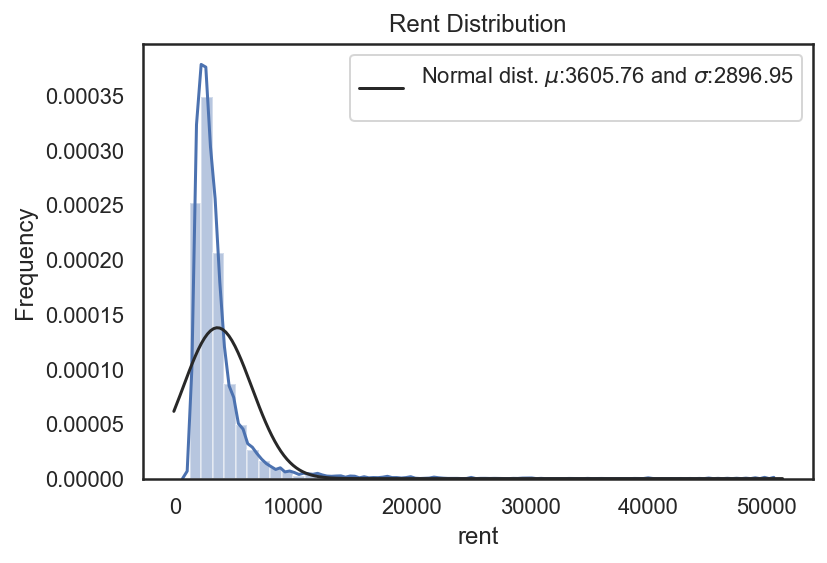

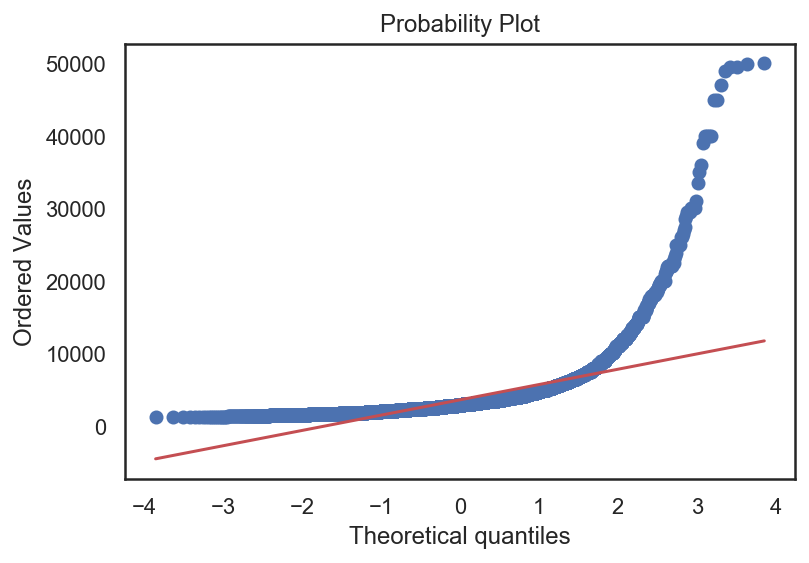

Skewness:6.282718976779915
Kurtosis:64.84190569996547


In [8]:
# Visualize Target Variable

sns.distplot(train_df['rent'], fit=norm)

(mu,sigma)= norm.fit(train_df['rent'])

print(f"mu: {mu:.2f}\nsigma:{sigma:.2}")

plt.legend([f'Normal dist. $\mu$:{mu:.2f} and $\sigma$:{sigma:.2f}\n'],
            loc='best')
plt.ylabel('Frequency')
plt.title('Rent Distribution')

fig = plt.figure()
res = stats.probplot(train_df['rent'], plot=plt)
plt.show()

print(f"Skewness:{train_df['rent'].skew()}")
print(f"Kurtosis:{train_df['rent'].kurt()}")

### Observations from Target Variable

- Skewness suggest:
    - Lack of symmetry in rent distribution
    - Mean and median are greater than the mode

- Kurtosis suggest:
    - Heavy tails in distribution
    - Lots of outliers in data

## Visualization of Features Against Rent

- Dividing categorical and numerical datatypes in dataframe

In [9]:
# Categorical Data
train_df.select_dtypes(include=['object']).columns

Index(['addr_unit', 'addr_street', 'addr_city', 'neighborhood', 'borough',
       'unit', 'line'],
      dtype='object')

In [10]:
# Numiercal Data 
train_df.select_dtypes(include=['int64','float64']).columns

Index(['building_id', 'bedrooms', 'bathrooms', 'size_sqft', 'addr_zip',
       'addr_lat', 'addr_lon', 'bbl', 'floor_count', 'year_built',
       'min_to_subway', 'has_doorman', 'has_elevator', 'has_fireplace',
       'has_dishwasher', 'is_furnished', 'has_gym', 'allows_pets',
       'has_washer_dryer', 'has_garage', 'has_roofdeck', 'has_concierge',
       'has_pool', 'has_garden', 'has_childrens_playroom', 'rent', 'no_fee',
       'floornumber'],
      dtype='object')

In [11]:
num_categorical = len(train_df.select_dtypes(include=['object']).columns)
num_numerical = len(train_df.select_dtypes(include=['int64','float64']).columns)
print(f"Categorical Features:{num_categorical}\nNumerical Features:{num_numerical}")
print(f"Total Features = {num_categorical+num_numerical}")


Categorical Features:7
Numerical Features:28
Total Features = 35


We have mostly numerical features and a couple categorical features... we will need to encode some of the most useful categorical features like neighborhoodand borough...

## Narrowing Down Optimal Features

- Lets look at which features would be most important in predicting rent 

- Creating a correlations matrix we can observe relationships

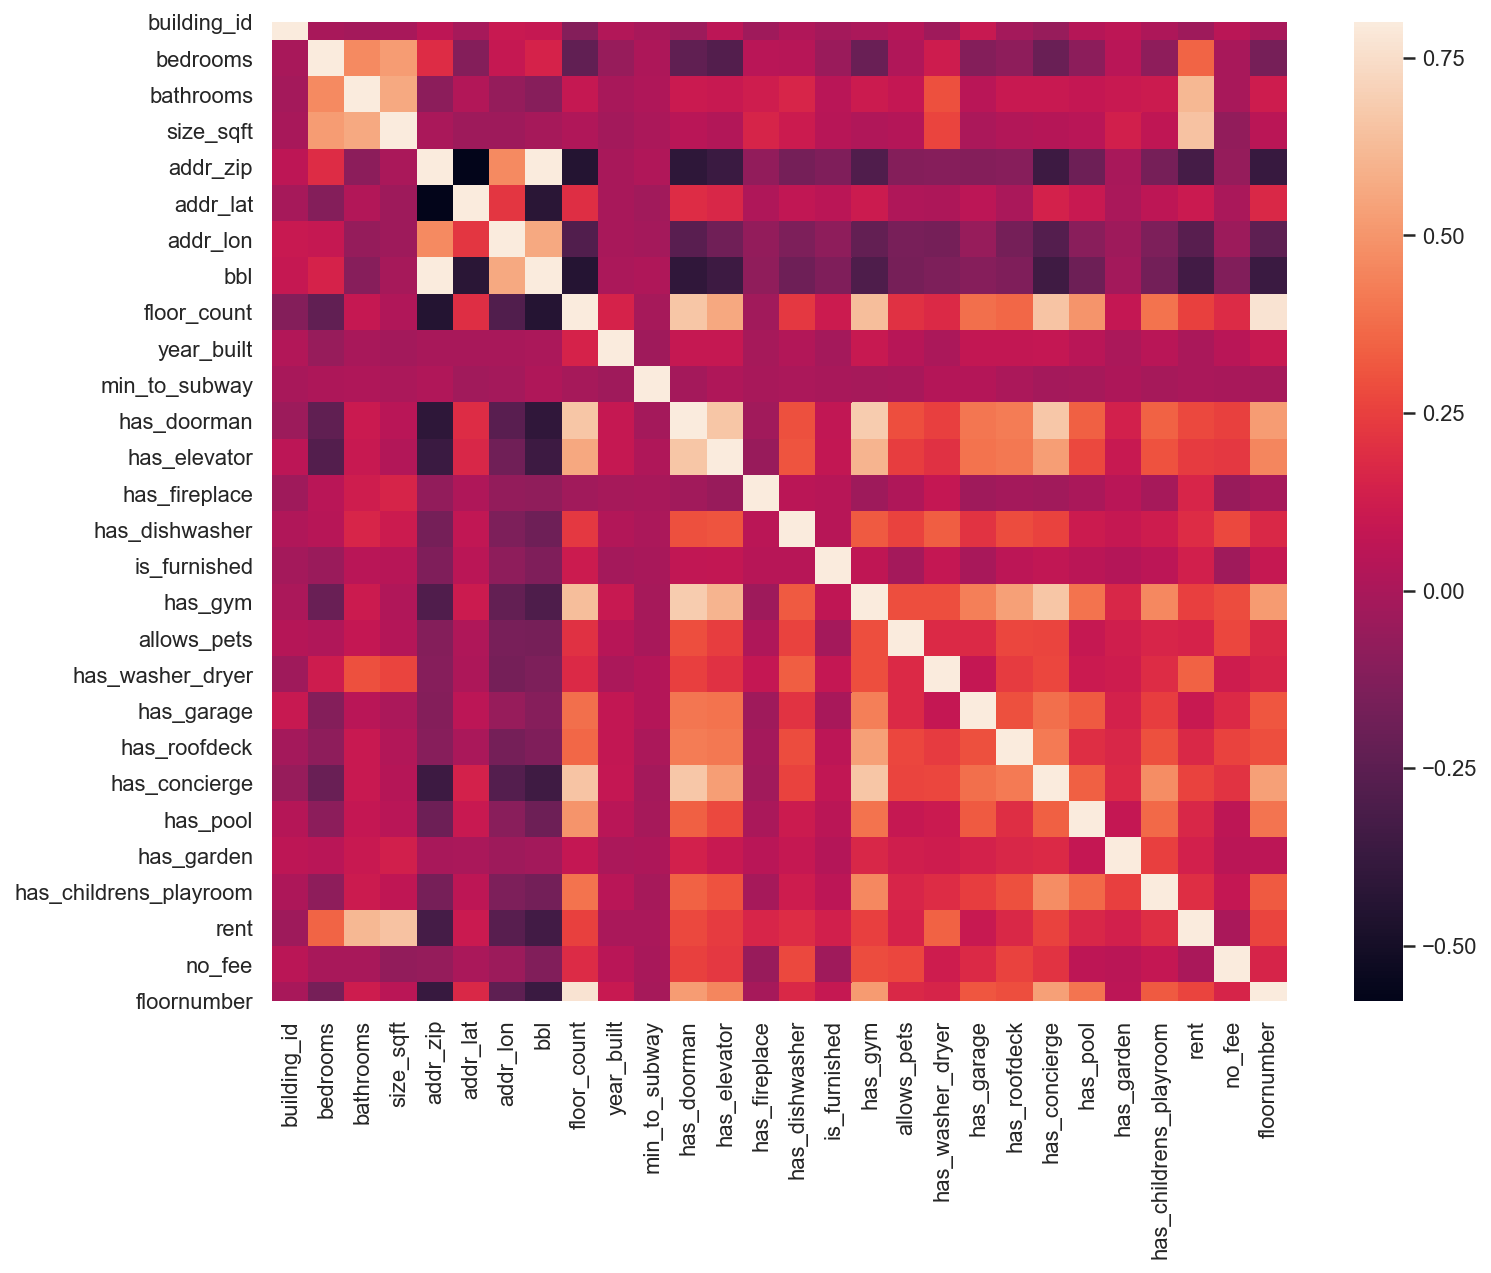

In [13]:
# Correlation Matrix Heatmap

corrmat = train_df.corr()
f, ax = plt.subplots(figsize=(12, 9))
sns.heatmap(corrmat, vmax=.8, square=True);

**Lots of features above, lets try an narrow the relationships down to the top 10.**

Index(['rent', 'size_sqft', 'bathrooms', 'bedrooms', 'has_washer_dryer',
       'has_doorman', 'floornumber', 'has_concierge', 'floor_count', 'has_gym',
       'has_elevator'],
      dtype='object')


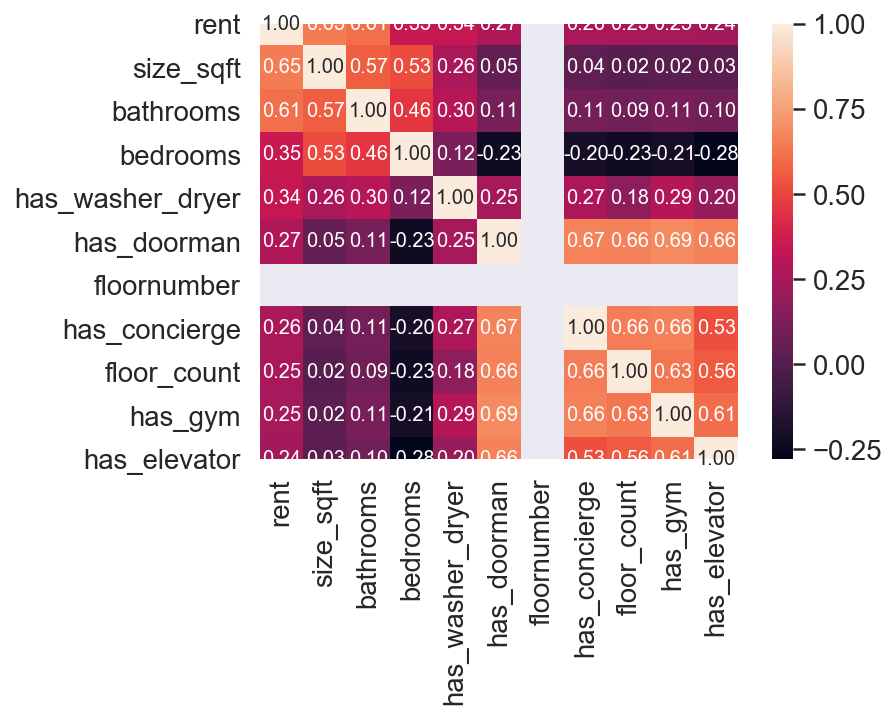

In [17]:
# Top k Heatmap

k = 11 #number of variables for heatmap
cols = corrmat.nlargest(k, 'rent')['rent'].index
print(cols)
cm = np.corrcoef(train_df[cols].values.T)
sns.set(font_scale=1.25)
hm = sns.heatmap(cm, cbar=True, annot=True, square=True, fmt='.2f', annot_kws={'size': 10}, yticklabels=cols.values, xticklabels=cols.values)
plt.show()

**Lets order them by most correlated to least for better understanding**

In [18]:
most_corr = pd.DataFrame(cols[1::])
most_corr.columns = ['Most Correlated Features']
most_corr

,Most Correlated Features
0,size_sqft
1,bathrooms
2,bedrooms
3,has_washer_dryer
4,has_doorman
5,floornumber
6,has_concierge
7,floor_count
8,has_gym
9,has_elevator


## Visualizing Features with Respect to Target

- After observing the 10 most correlated features we can plot them to visualize how they interact better
- This will also give us intuition about outliers and any wierd anomalies in the data

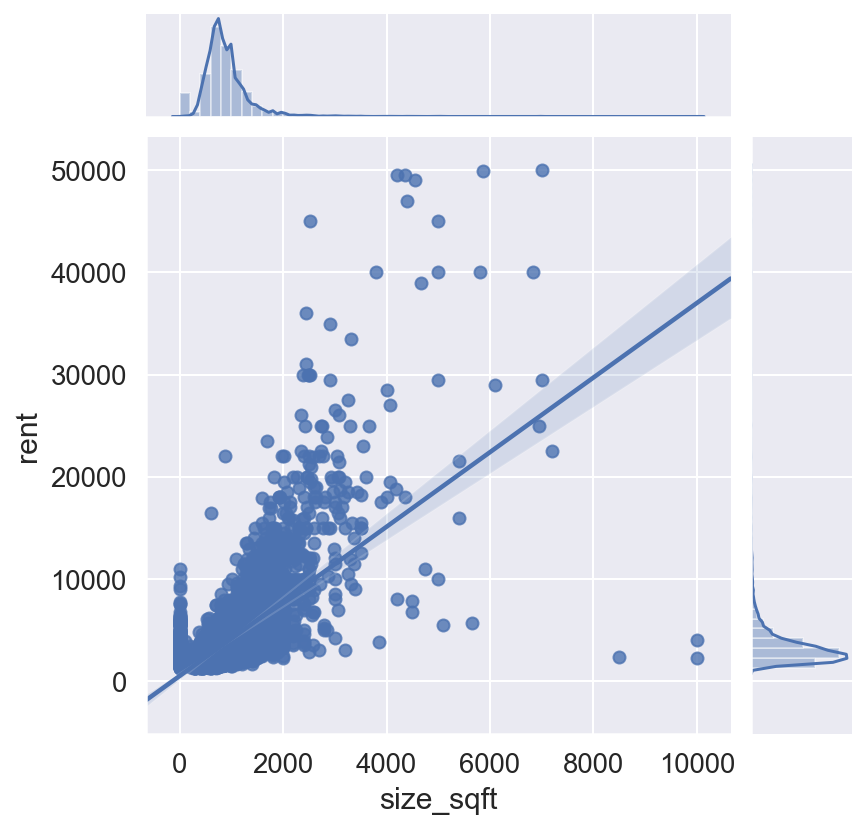

In [19]:
# size_sqft vs rent

sns.jointplot(x=train_df['size_sqft'], y=train_df['rent'], kind='reg')


**Observations**

- `size_sqft` seems to be positively correlated with `rent` 
- Outliers exist for `size_sqft` > 8000
- Potential issues with `size_sqft` = 0 

Lets remove the outliers as linear regression models are less accurate with tons of outliers

In [20]:
# Remove outliers

train_df = train_df.drop(train_df[(train_df['size_sqft']>8000) 
                         & (train_df['rent']<10000)].index).reset_index(drop=True)

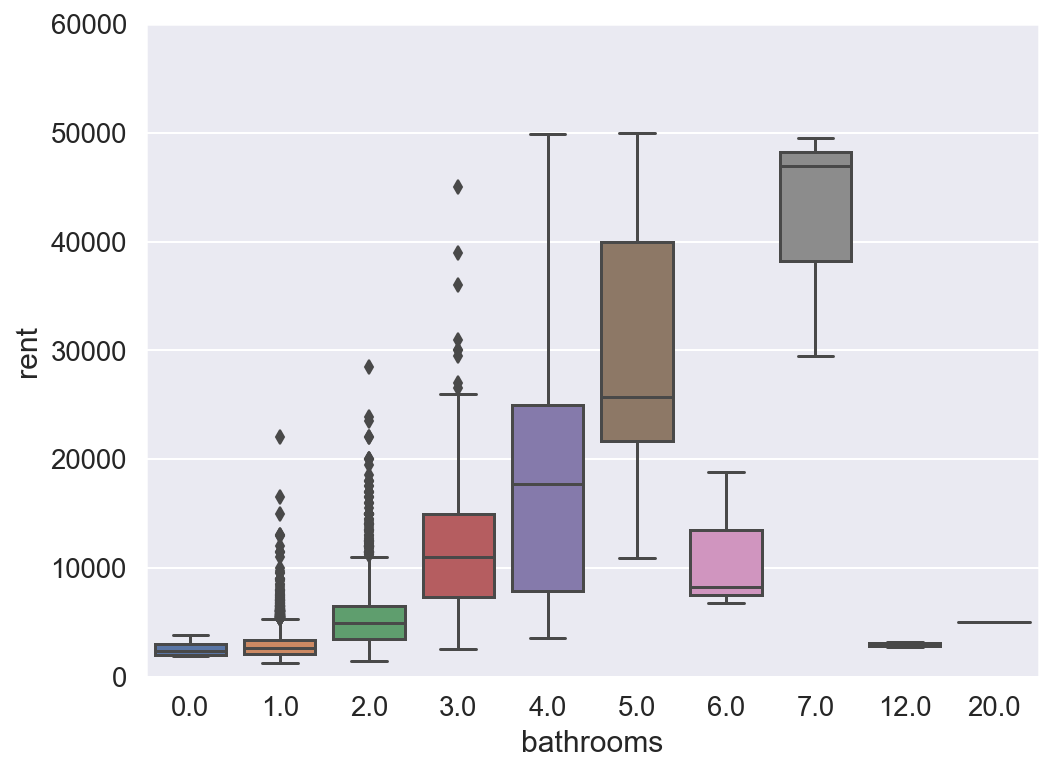

In [21]:
# bathrooms vs rent
var = 'bathrooms'
data = pd.concat([train_df['rent'], train_df[var]], axis=1)
f, ax = plt.subplots(figsize=(8, 6))
fig = sns.boxplot(x=var, y="rent", data=data)
fig.axis(ymin=0, ymax=60000);

**Observations**

- bathrooms seems positively correlated with rent
- there seems to be outliers for bathrooms > 12 and equal to 6
- looks like listing with 0 bathroom are a bit odd we'll take care of it when we handle missing values

Lets remove the outliers for better modeling performance

In [24]:
# remove bathroom outliers

train_df = train_df.drop(train_df[(train_df['bathrooms']>=12) 
                         & (train_df['rent']<10000)].index).reset_index(drop=True)

train_df = train_df.drop(train_df[(train_df['bathrooms']==6) 
                         & (train_df['rent']<20000)].index).reset_index(drop=True)


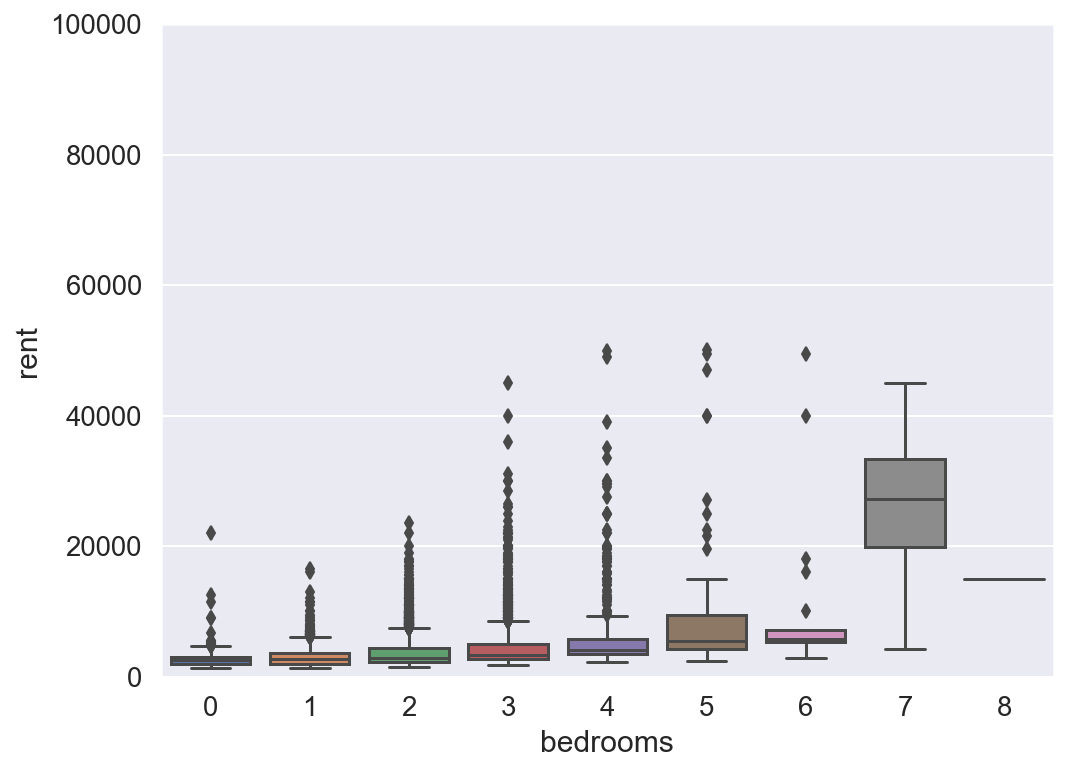

In [25]:
# bedrooms vs rent
var = 'bedrooms'
data = pd.concat([train_df['rent'], train_df[var]], axis=1)
f, ax = plt.subplots(figsize=(8, 6))
fig = sns.boxplot(x=var, y="rent", data=data)
fig.axis(ymin=0, ymax=100000);

In [28]:
train_df[(train_df['bedrooms'] ==0)&(train_df['rent']>20000)]

,addr_unit,building_id,bedrooms,bathrooms,size_sqft,addr_street,addr_city,addr_zip,addr_lat,addr_lon,...,has_pool,has_garden,has_childrens_playroom,rent,no_fee,neighborhood,borough,unit,floornumber,line
6070,STREET-LEVEL,722422,0,1.0,880.0,1409 WEST 7 STREET,Brooklyn,11204,40.610968,-73.980994,...,0,0,0,22000,0,Bensonhurst,Brooklyn,STREETLEVEL,NaN,NaN


**Observations**

-`bathrooms` is postively correlated with rent
- outiers present with `bathrooms` = 8
- We might need to remove bathrooms = 6 as it seems like a outlier but we'll leave it for now
- looks like the listing with bathroom = 0 and rent over 20k is an outlier atfer some research online

Lets remove the outliers for better modeling performance


In [29]:
# remove bedroom outliers
train_df = train_df.drop(train_df[(train_df['bedrooms']>=8) 
                         & (train_df['rent']<20000)].index).reset_index(drop=True)

train_df = train_df.drop(train_df[(train_df['bedrooms'] ==0)&(train_df['rent']>20000)].index).reset_index(drop=True)

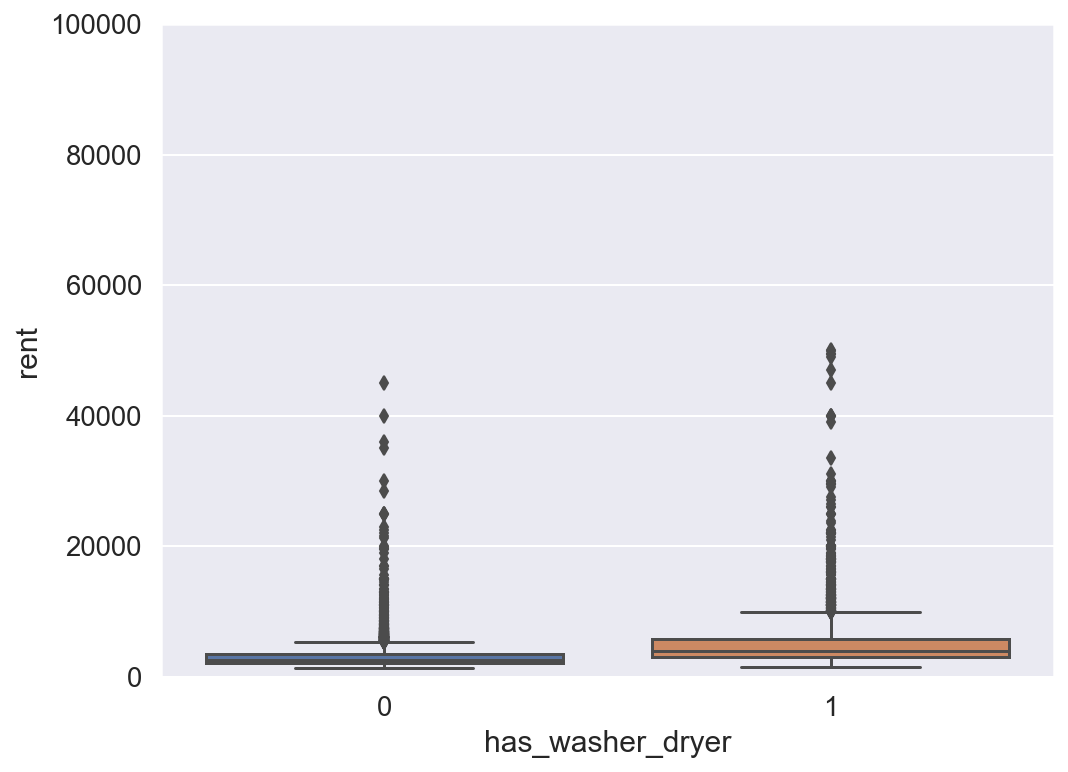

In [30]:
# has_washer_dryer vs rent
var = 'has_washer_dryer'
data = pd.concat([train_df['rent'], train_df[var]], axis=1)
f, ax = plt.subplots(figsize=(8, 6))
fig = sns.boxplot(x=var, y="rent", data=data)
fig.axis(ymin=0, ymax=100000);

**Observations**

- seems like listings with `washer/dryers` fetch a higher average price

Nothing to be removed here

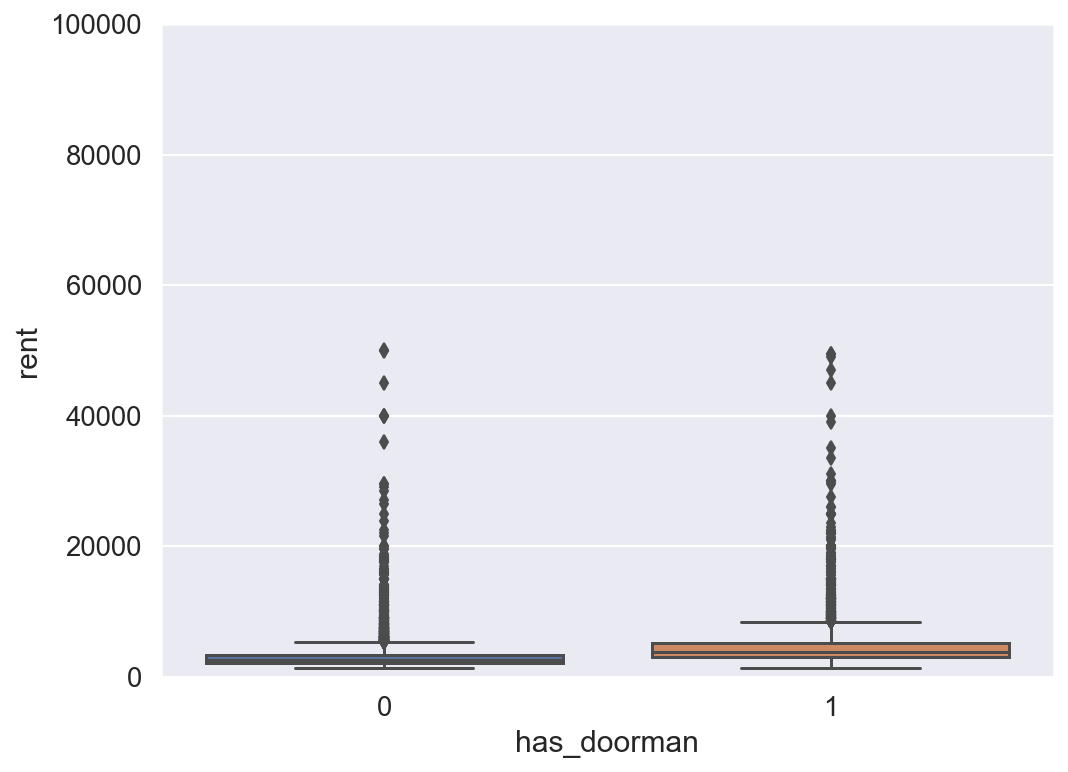

In [31]:
# has_doorman vs rent

var = 'has_doorman'
data = pd.concat([train_df['rent'], train_df[var]], axis=1)
f, ax = plt.subplots(figsize=(8, 6))
fig = sns.boxplot(x=var, y="rent", data=data)
fig.axis(ymin=0, ymax=100000);

**Observations**

- Again, seems like listings with `has_doorman` fetch higher avg prices.

Nothing to removed here

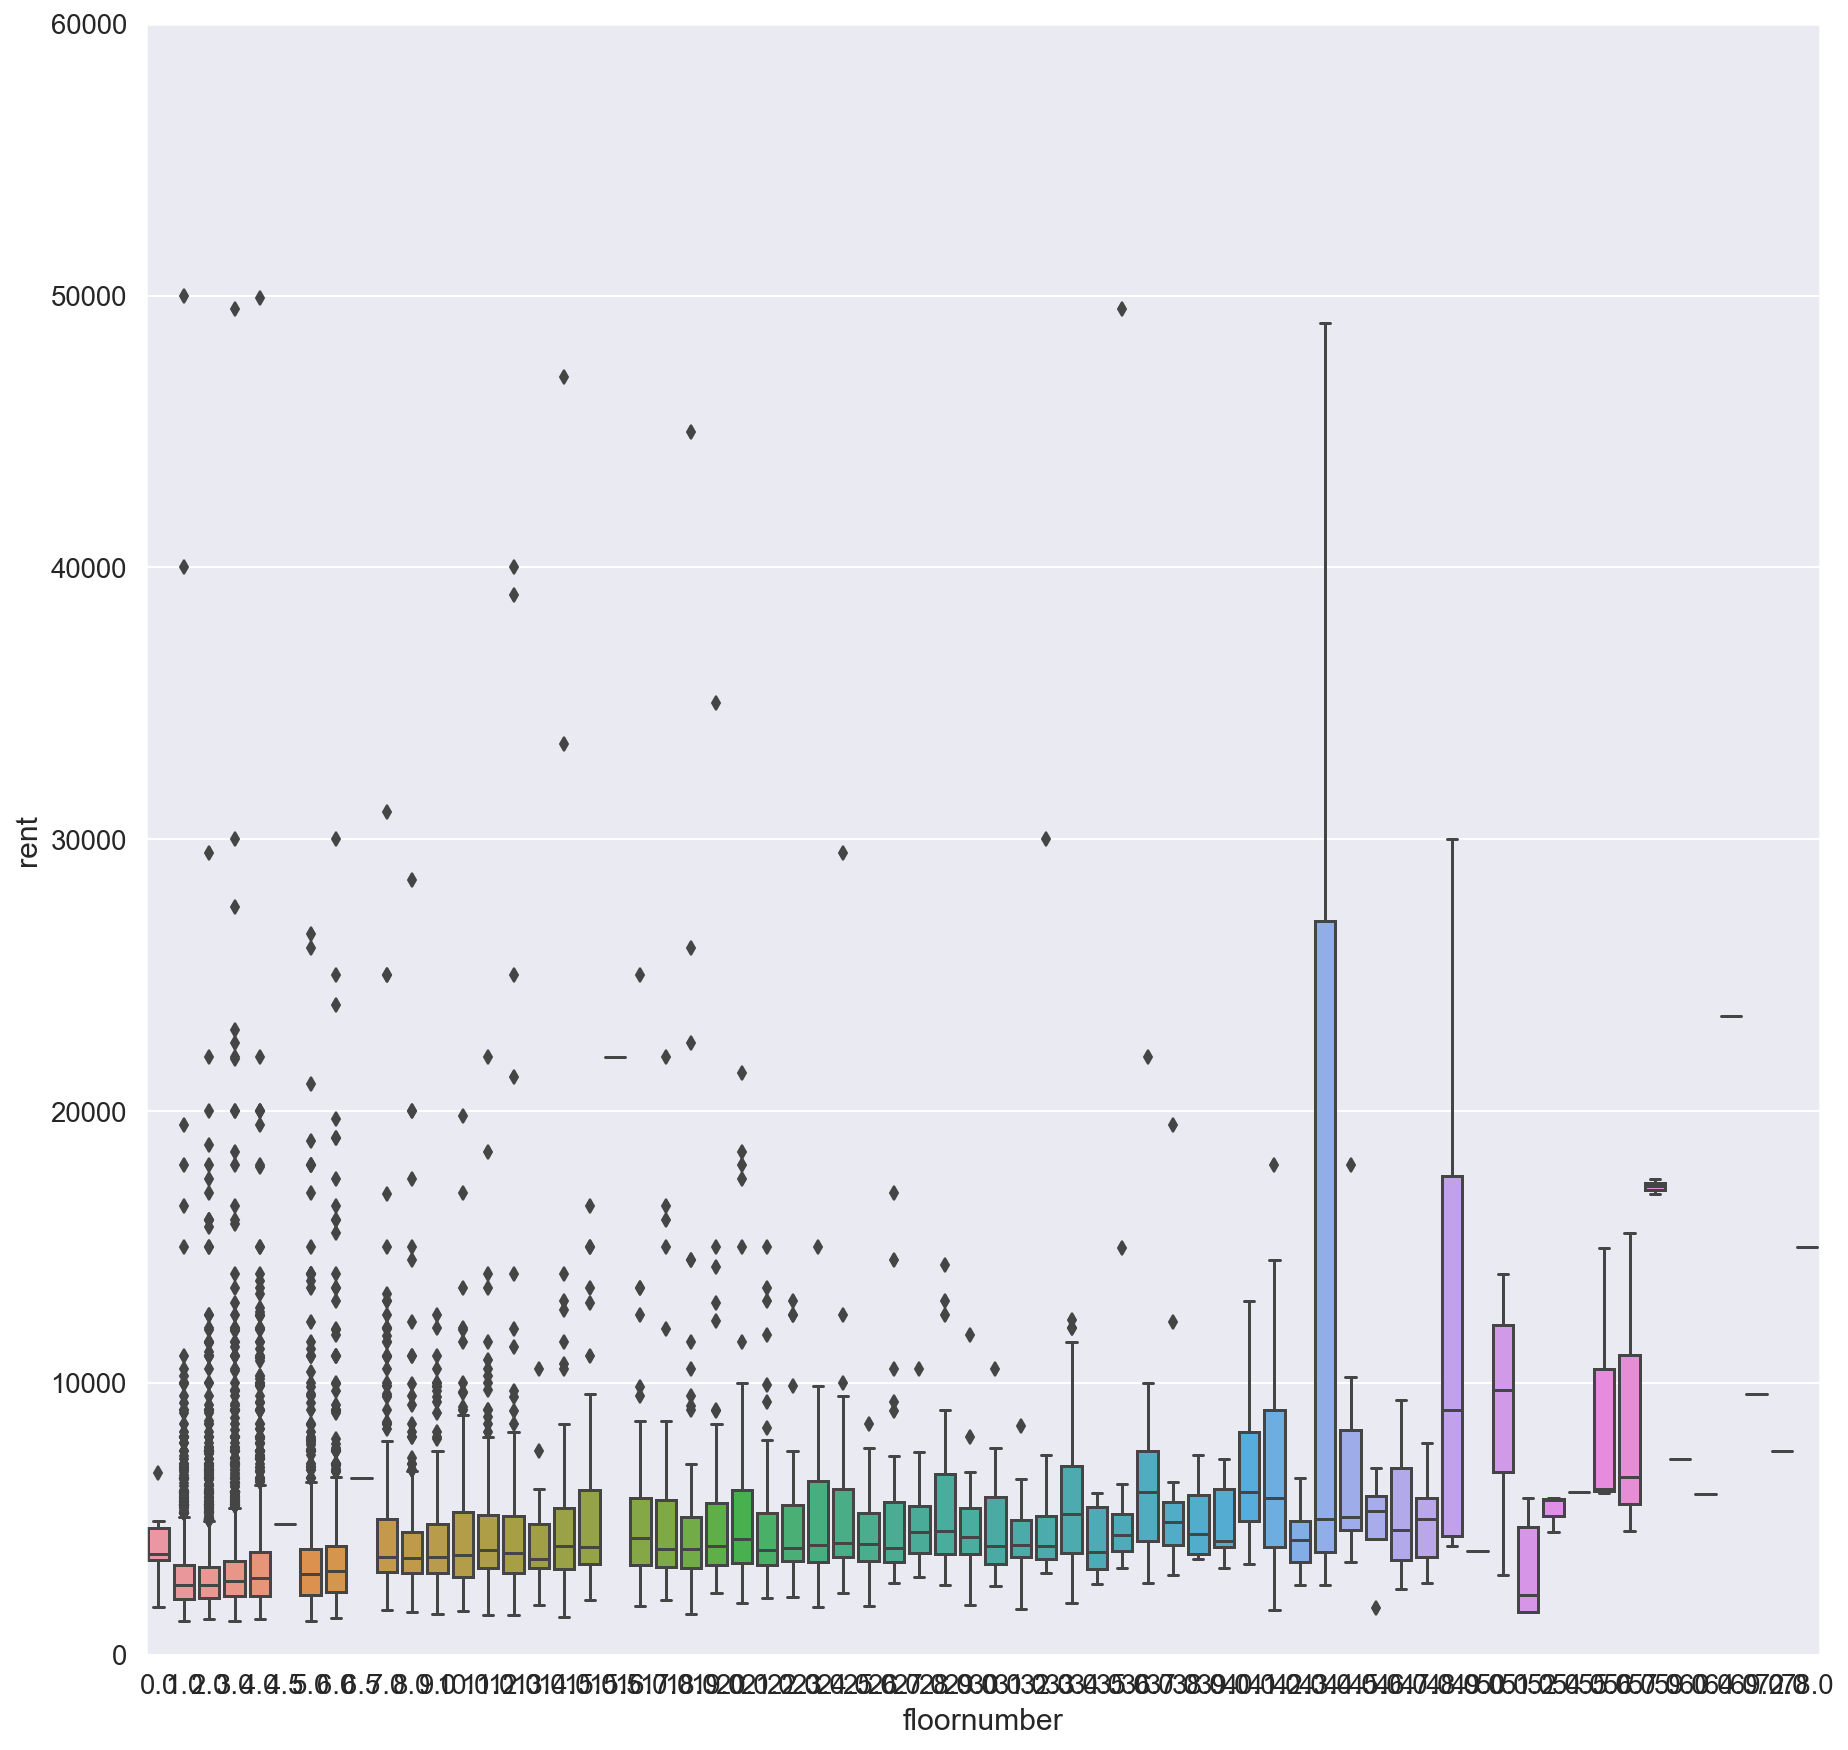

In [36]:
# floornumber vs rent

var = 'floornumber'
data = pd.concat([train_df['rent'], train_df[var]], axis=1)
f, ax = plt.subplots(figsize=(15, 15))
fig = sns.boxplot(x=var, y="rent", data=data)
fig.axis(ymin=0, ymax=60000);

**Observations** 

- Suggest higher `floornumbers` fetch slightly higher prices
- there seems to be a steady correlation as you increase floornumber
- floornumbers = 0 might be a problem

we will only get rid of a couple outliers like floornumber = 42,49,51 as those seem to be the most extreme cases.

In [37]:
train_df = train_df.drop(train_df[(train_df['floornumber'] == 42)&(train_df['rent']<10000)].index).reset_index(drop=True)
train_df = train_df.drop(train_df[(train_df['floornumber'] == 49)&(train_df['rent']<10000)].index).reset_index(drop=True)
train_df = train_df.drop(train_df[(train_df['floornumber'] == 51)&(train_df['rent']<10000)].index).reset_index(drop=True)

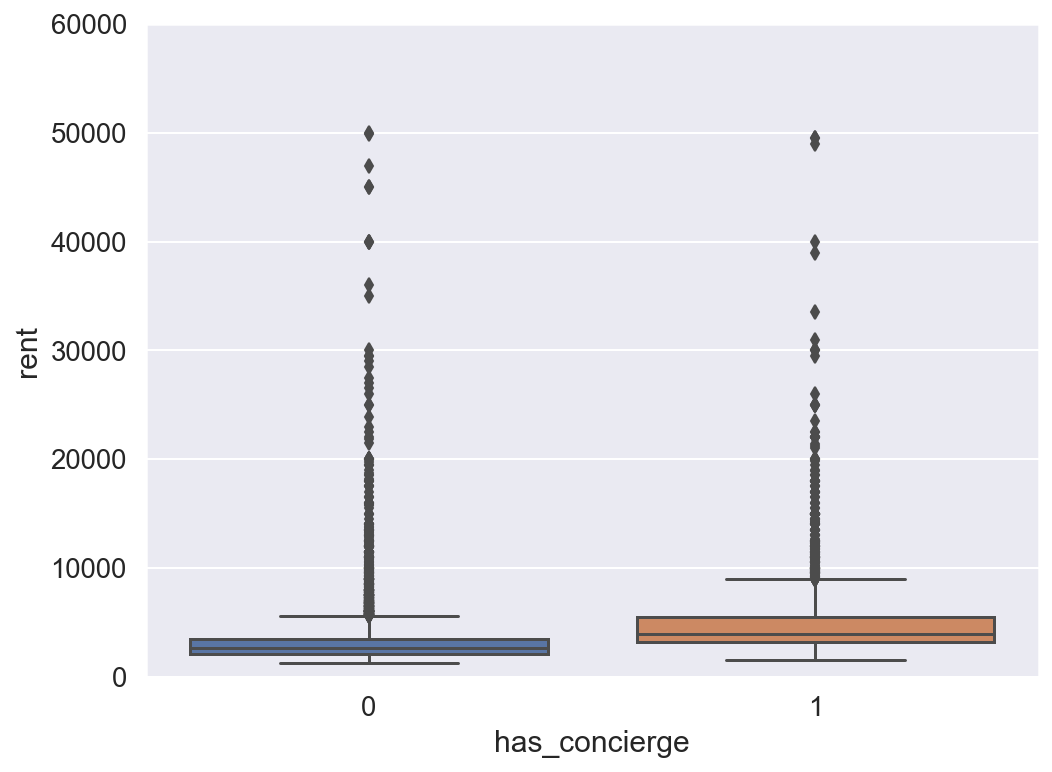

In [38]:
# has_concierge vs rent

var = 'has_concierge'
data = pd.concat([train_df['rent'], train_df[var]], axis=1)
f, ax = plt.subplots(figsize=(8, 6))
fig = sns.boxplot(x=var, y="rent", data=data)
fig.axis(ymin=0, ymax=60000);


**Observations**

- Looks like listings with `has_concierge` = True fetch higher prices

Nothing surprising here and nothing to remove


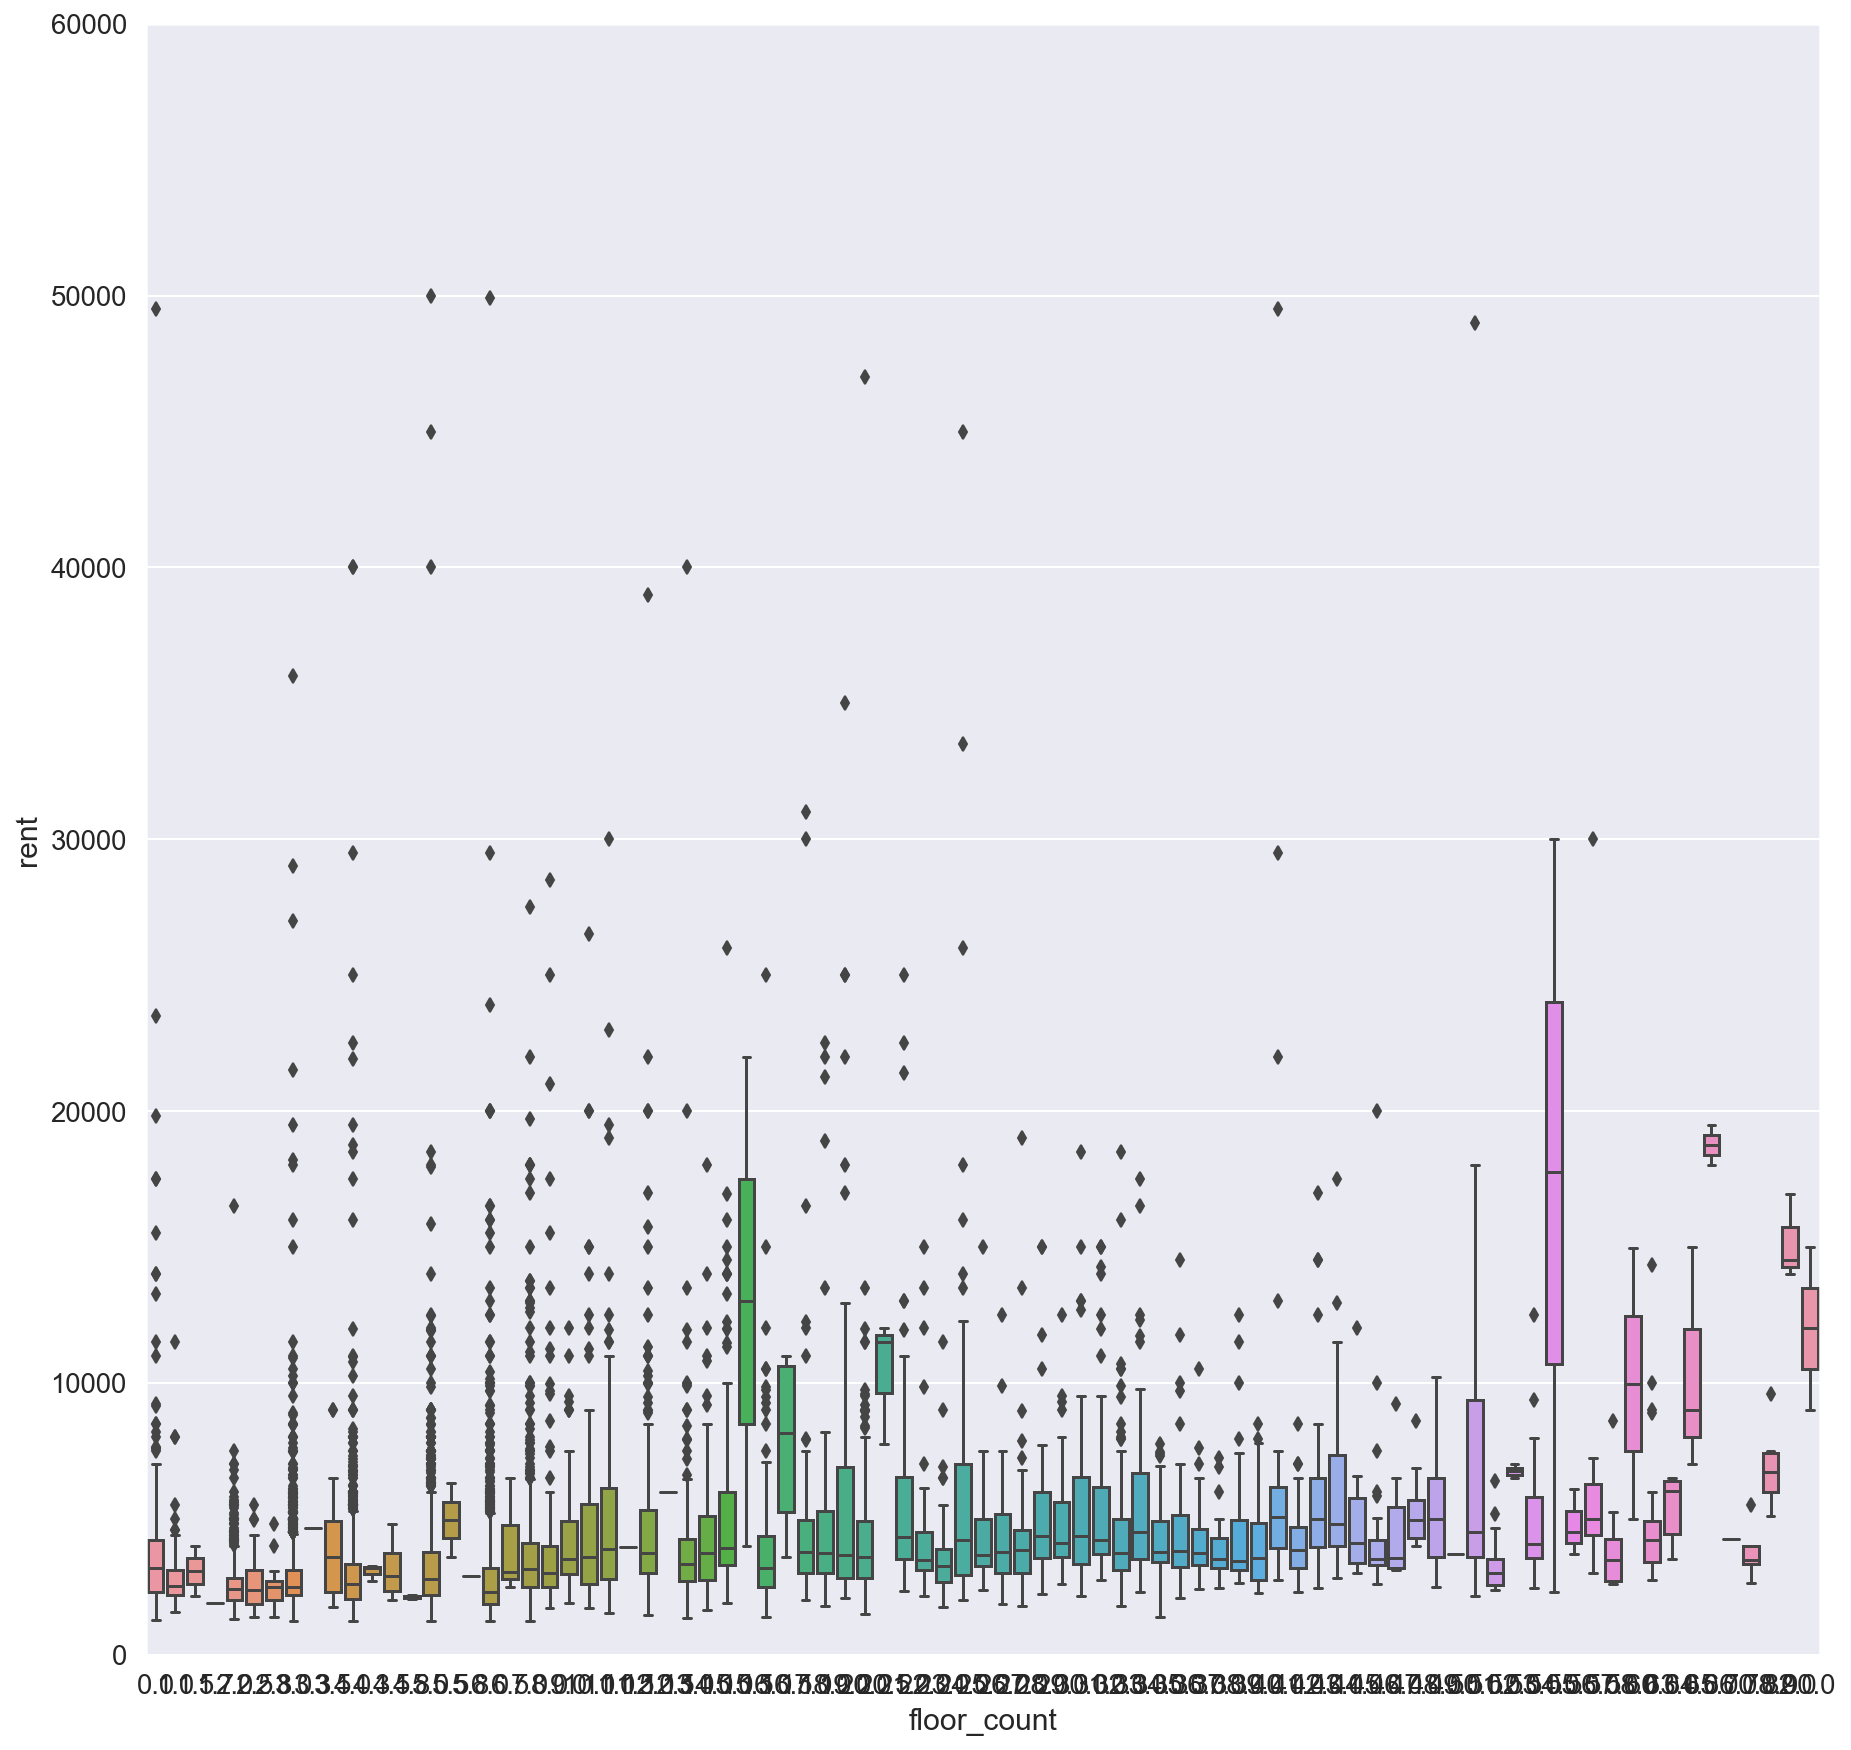

In [39]:
# floor_count vs rent

var = 'floor_count'
data = pd.concat([train_df['rent'], train_df[var]], axis=1)
f, ax = plt.subplots(figsize=(15, 15))
fig = sns.boxplot(x=var, y="rent", data=data)
fig.axis(ymin=0, ymax=60000);


**Observations**

- Seems like there is a slight increase in rent as `floor_count` increases, but very minimal/ hard to tell
- Potential outlier towards higher `floor_count`

Same as `floornumber`, as some listings with higher `floor_count` fetch lower prices but could be because a high building
in a bad neighborhood is not going to fetch a higher price for now we will leave it.

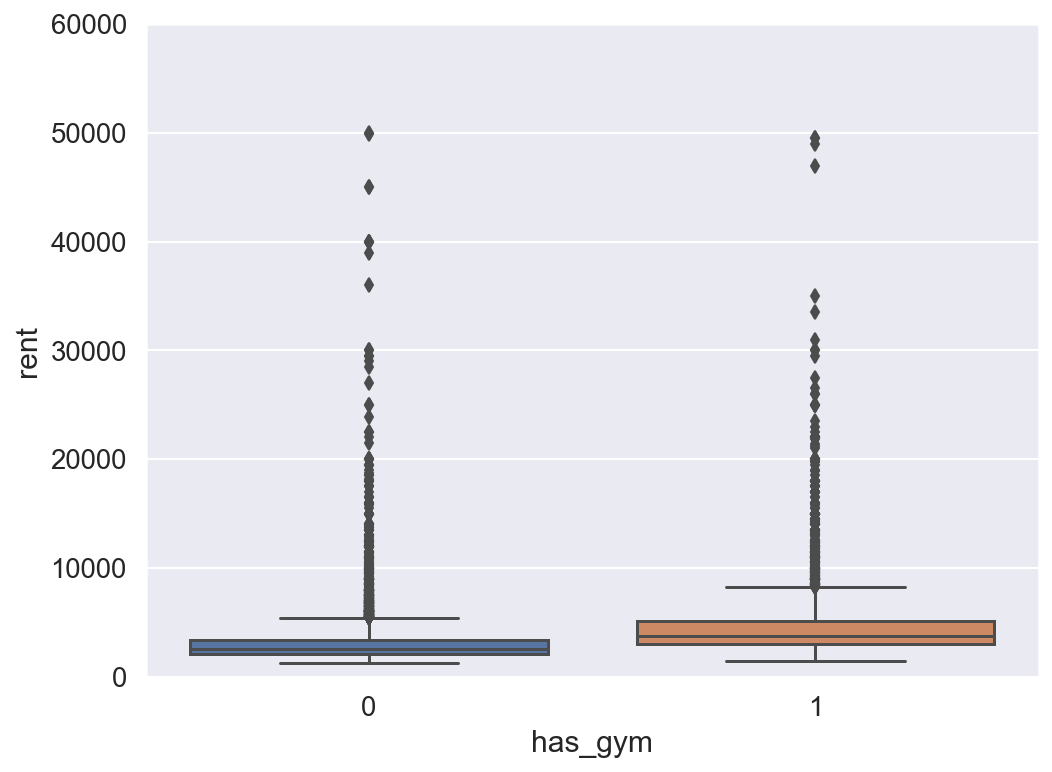

In [40]:
# has_gym vs rent

var = 'has_gym'
data = pd.concat([train_df['rent'], train_df[var]], axis=1)
f, ax = plt.subplots(figsize=(8, 6))
fig = sns.boxplot(x=var, y="rent", data=data)
fig.axis(ymin=0, ymax=60000);

**Observations**

- Listings with `has_gym` go for higher prices 

Nothing suprising here as listings with a gym have higher average prices, potential outliers could exist 
as listings with no gym have prices larger than those with a gym. 

For now we leave it

borough
Manhattan        4684.669177
Brooklyn         2965.680746
Queens           2288.625557
Staten Island    2187.692308
Bronx            2169.350000
Name: rent, dtype: float64


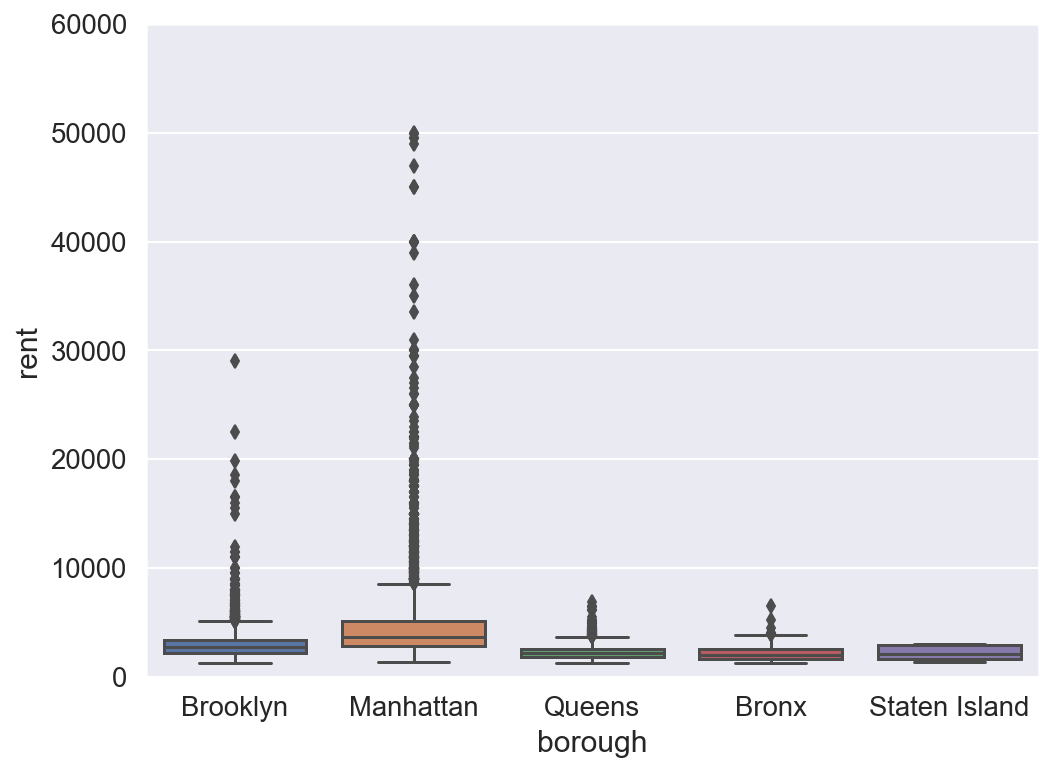

In [41]:
# borough vs rent
var = 'borough'

print(train_df.groupby(var)['rent'].mean().sort_values(ascending=False))

data = pd.concat([train_df['rent'], train_df[var]], axis=1)
f, ax = plt.subplots(figsize=(8, 6))
fig = sns.boxplot(x=var, y="rent", data=data)
fig.axis(ymin=0, ymax=60000);



**Observations**

- Looks like most of listings are in Manhattan and Brooklyn
- Those two seem like the most expensive borough 
- from mean of rent per borough seems to suggest so

Doesnt seem like outliers are present, will need to encode borough in order to be able to put it through regressor
We'll save this for later

addr_zip
10461    1350.000000
11421    1414.000000
10452    1423.333333
10469    1450.000000
10460    1450.000000
            ...     
10065    6951.625000
10012    7086.284314
10282    7540.944444
10007    7621.400000
10013    9991.008403
Name: rent, Length: 149, dtype: float64


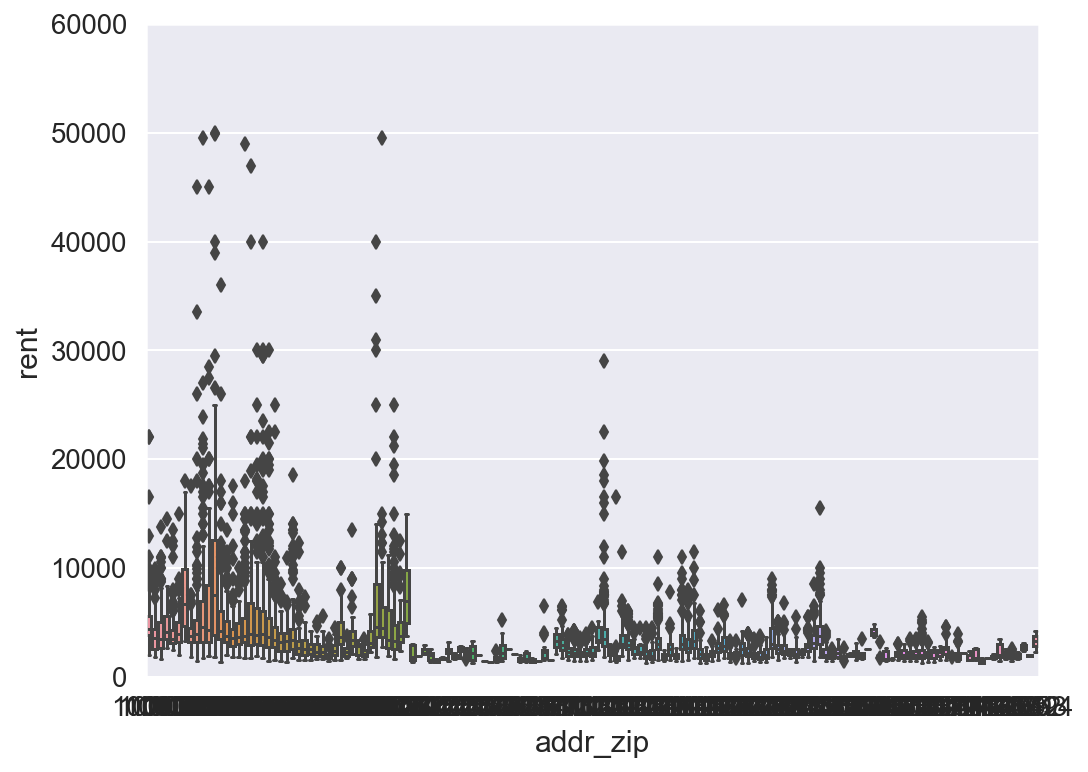

In [42]:
# zipcodes vs rent
var = 'addr_zip'
zip_group = train_df.groupby(var)['rent'].mean().sort_values()
print(zip_group)

data = pd.concat([train_df['rent'], train_df[var]], axis=1)
f, ax = plt.subplots(figsize=(8, 6))
fig = sns.boxplot(x=var, y="rent", data=data)
fig.axis(ymin=0, ymax=60000);

**Observations**

- Most of the listings seem to be in lower value zipcodes, i think ther are mostly in manhattan and brooklyn
- Hard to see a correlations between this and rent in terms of higher zipcode values
- Certain zipcodes do fetch higher avg rent prices

From the graphs and statistics of avg rent per zipcode we see there prices do vary depending on zipcode. There is
a hierarchy in terms of zip code avg rent prices. This will need to be encoded in order to put in regressor. 

We will encode the addr_zip from out groups from lowest to highest avg rent prices.

*Example*:

`encoded(addr_zip) = 0` *lowest*

`encoded(addr_zip) = len(addr_zip)` *highest*

neighborhood
Pelham Bay           1350.000000
Bedford Park         1360.000000
Van Nest             1400.000000
Highbridge           1423.333333
College Point        1450.000000
                        ...     
Flatiron             6128.088050
Chinatown            6267.428571
Greenwich Village    6645.244898
Soho                 9321.645570
Tribeca              9591.939655
Name: rent, Length: 146, dtype: float64


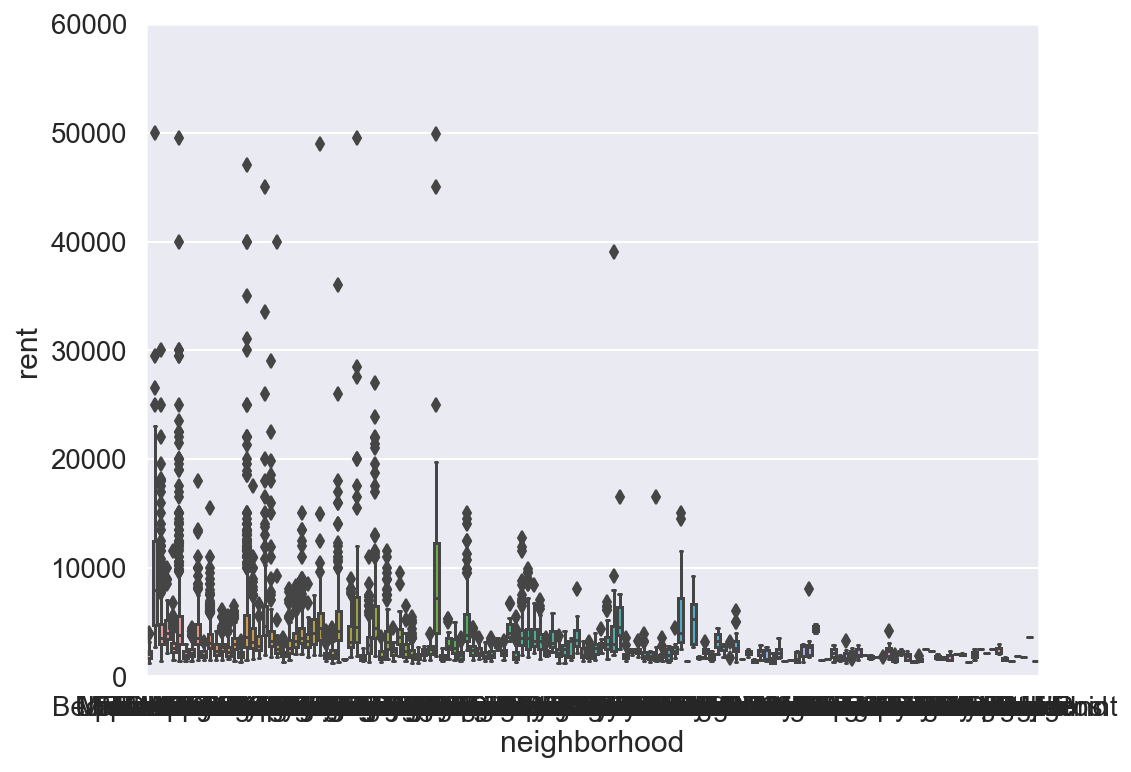

In [43]:
# neighbrhood vs rent
var = 'neighborhood'
neighborhood_group = train_df.groupby(var)['rent'].mean().sort_values()
print(neighborhood_group)

data = pd.concat([train_df['rent'], train_df[var]], axis=1)
f, ax = plt.subplots(figsize=(8, 6))
fig = sns.boxplot(x=var, y="rent", data=data)
fig.axis(ymin=0, ymax=60000);



**Observations**

- Similar to addr_zip, most listings seem to be concentrated in certain neighbohoods
- Certain neighborhoods fetch higher prices

We will take the same approach as addr_zip and encode neighborhoods to put in a regressor

We will encode them in the same way... based on our grouping we give the 'cheapest' neighborhood a lower
encoded values than more expensive neighborhoods

*example*

`encoded(neighborhood) = 0` *lowest*

`encoded(neighborhood) = len(neighborhood)` *highest*

## **Imputation and Addressing Missing Values**

- We will look for missing values and values that arent NaN but seem 'missing' in the sense that they dont make sense. Like 0 bathrooms as, to my knowledge, all apartments have a bathroom.

- We will first combine the train and test sets and apply the same impuations to each, we are combining them as they will both serve as training data for submission 1.

In [44]:
# Combine Datasets

ntrain_df = train_df.shape[0]
ntest_df = test_df.shape[0]
target_train = train_df.rent.values
target_test = test_df.rent.values
all_data_df = pd.concat((train_df, test_df)).reset_index(drop=True)
all_data_df.drop(['rent'], axis=1, inplace=True)
print(f"Train data size is : {train_df.shape}")
print(f"Test data size is : {test_df.shape}")
print(f"Combined dataset size is : {all_data_df.shape}")


Train data size is : (11974, 35)
Test data size is : (2000, 35)
Combined dataset size is : (13974, 34)


### Adding NaN's to Values That Don't Make Sense

- Make listings with `size_sqft = 0` into `NaN` as its not possible to exist without size
- Make listings with `bathrooms = 0` into `NaN` as all apartments have bathrooms, could be due to error in observation
- Make listings with `bedrooms = 0` into `NaN` as most of these listings I suspect are studio apartments and dont technically have private bedrooms but are technically bedrooms so we will count them as so.

In [45]:
# size_sqft = 0 to nan
all_data_df.loc[all_data_df['size_sqft']==0,'size_sqft'] = np.nan

In [ ]:
# # bathrooms = 0 to nan
# all_data_df.loc[all_data_df['bathrooms']==0,'bathrooms'] = np.nan

In [ ]:
# # bedrooms = 0 to nan
# all_data_df.loc[all_data_df['bedrooms']==0,'bedrooms'] = np.nan

### Lets Visually See What Missing in Our Dataset

In [46]:
# Find NaN Ratio of Dataset

all_data_na = (all_data_df.isnull().sum() / len(all_data_df)) * 100
all_data_na = all_data_na.drop(all_data_na[all_data_na == 0].index).sort_values(ascending=False)[:30]
missing_data = pd.DataFrame({'Missing Ratio':all_data_na})
missing_data

,Missing Ratio
line,29.519107
floornumber,10.712752
size_sqft,7.263489
year_built,3.327608
min_to_subway,1.023329
unit,0.801488
addr_unit,0.772864
neighborhood,0.021468


Text(0.5, 1.0, 'Percent missing data by feature')

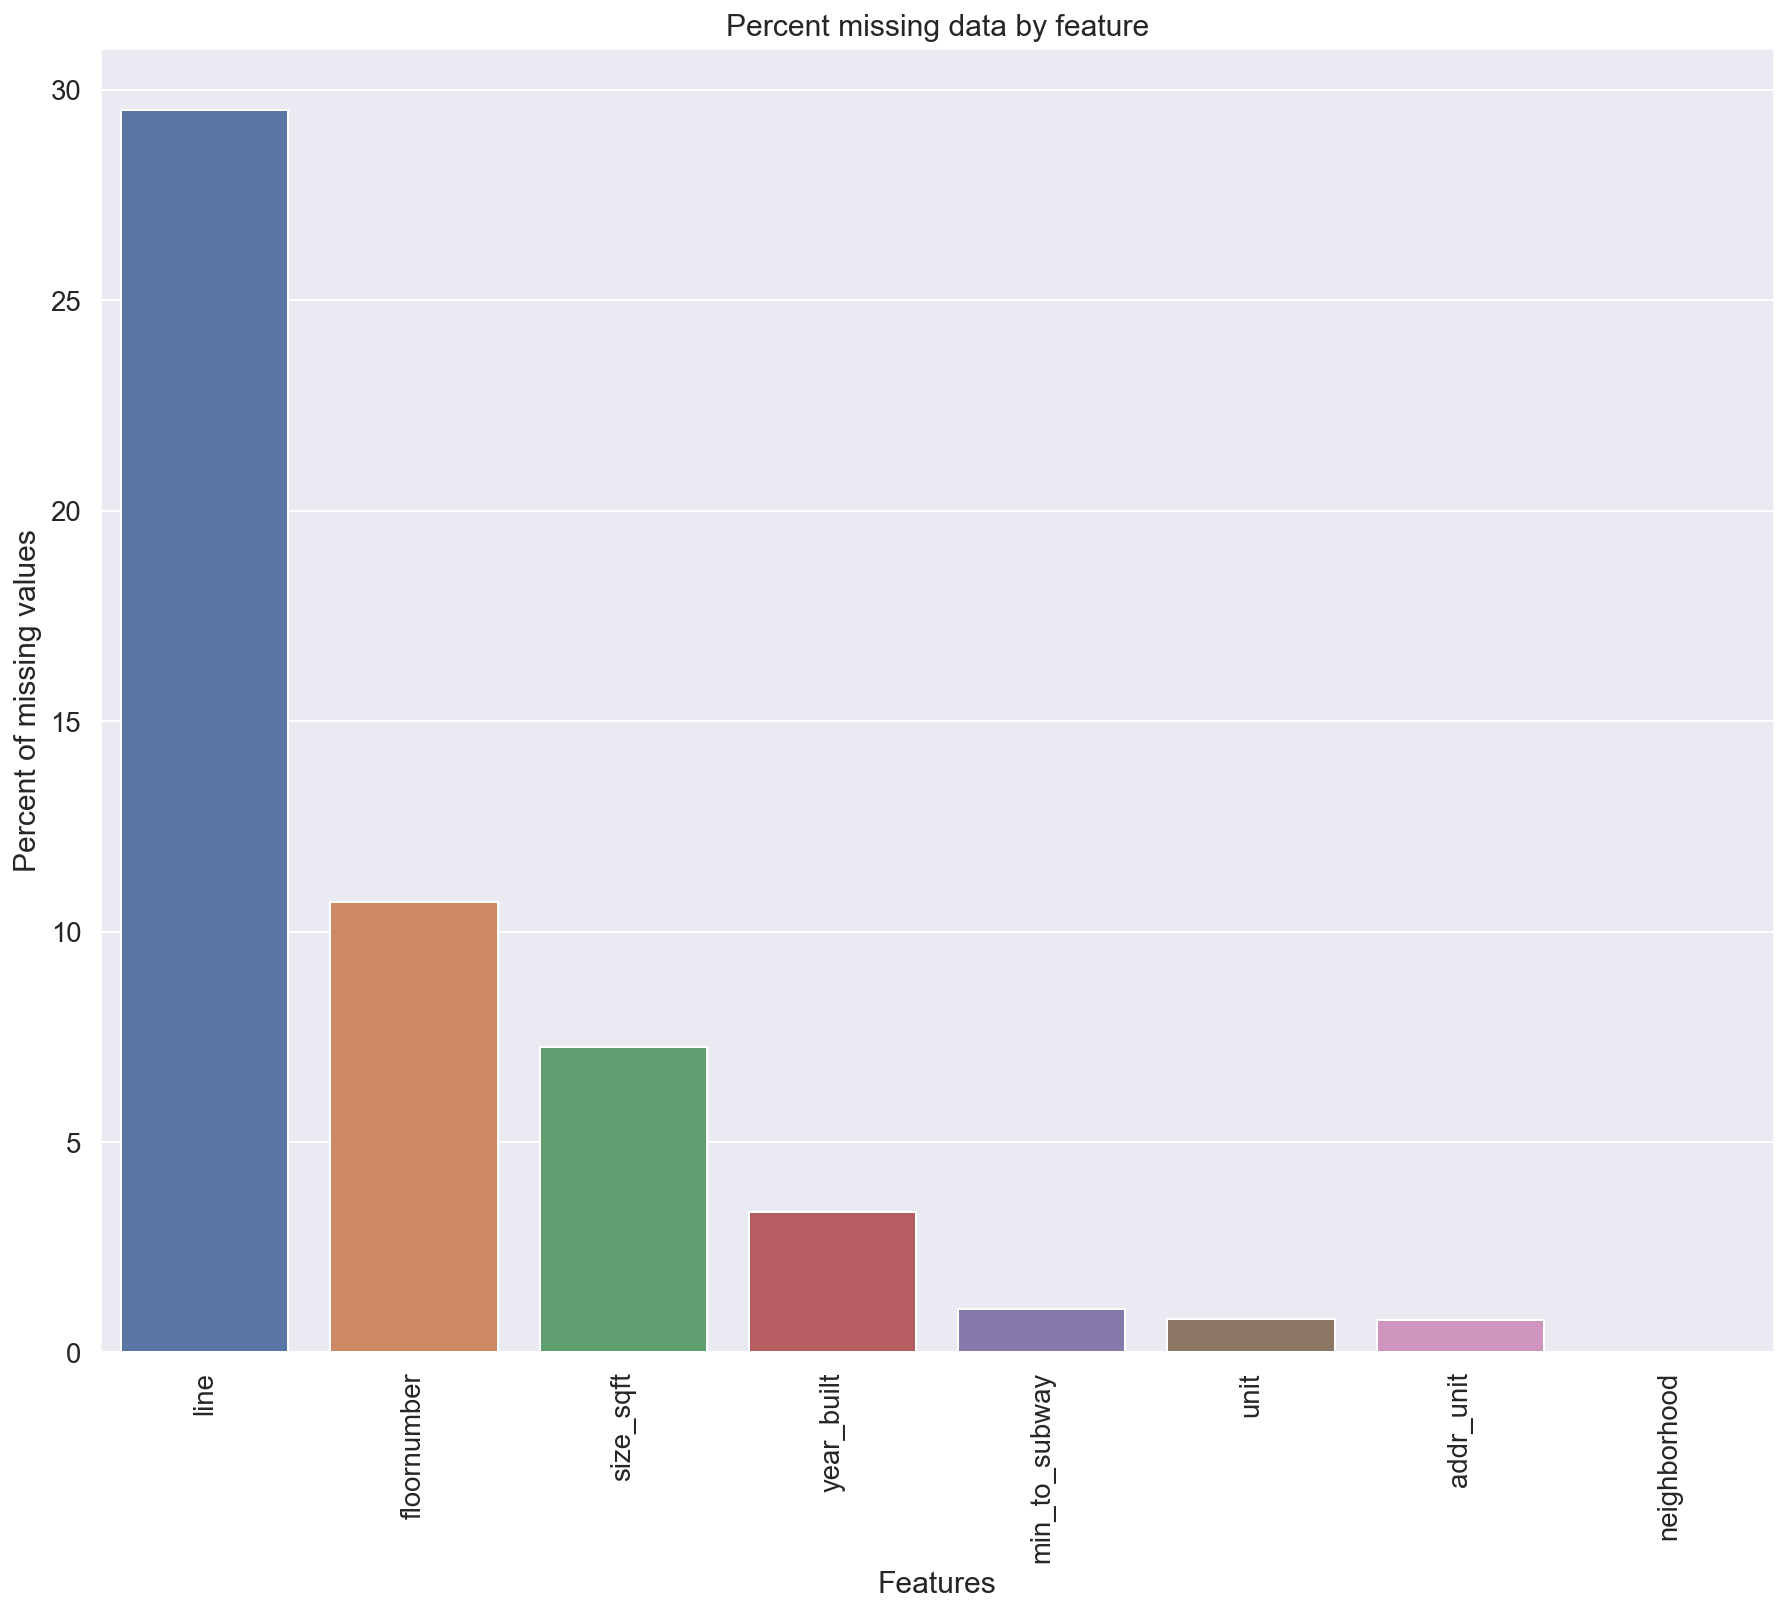

In [47]:
# Percent missing data by feature

f, ax = plt.subplots(figsize=(15, 12))
plt.xticks(rotation='90')
sns.barplot(x=all_data_na.index, y=all_data_na)
plt.xlabel('Features', fontsize=15)
plt.ylabel('Percent of missing values', fontsize=15)
plt.title('Percent missing data by feature', fontsize=15)

**Lets impute values baded on avg for numeric data and mode for categorical data**

**Every missing column will be imputed with avg composed from groupby objects that seem most appropriate**

- We will impute `line` from other listings close to it, i.e zip code, and __the most occuring value__
- impute `bedrooms` by filling all bedrooms that were __0 to 1__
- impute `floornumber` with __avg floor number value__ in column and __round to nearest integer__
- impute `size_sqft` with __avg value__ for other listings with __same bedroom size__ as those generally account for how big an apartment is.
- impute `year_built` by the __avg year_built__ of listings in __same zipcode__ 
- impute `min_to_subway` by __avg time to subway__ of other listings in the __same zipcode__
- impute `unit` will __most occuring units__ in unit column
- impute `addr_unit` same as `unit`
- impute `bathrooms` that were originally __0 with 1__ as most places *usually* have 1 bathrooms
- impute missing `neighborhood` with __most occuring neighborhood__ in listing __zip code__


In [48]:
# impute missing line values using zipcode and most frequent line in that area
all_data_df['line'] = all_data_df.groupby('addr_zip')['line'].transform(lambda x: x.fillna(stats.mode(x).mode[0]))

#impute missing bedroom values with 1 as they were all 0 before 
all_data_df['bedrooms'].fillna(1,inplace=True)

#impute floornumber missing values with mean floornumber
all_data_df['floornumber'].fillna(all_data_df['floornumber'].mean(),inplace=True)
all_data_df['floornumber'] = all_data_df['floornumber'].round(0).astype(int)

#impute size_sqft missing values with mean size of # of bedrooms
all_data_df['size_sqft'] = all_data_df.groupby('bedrooms')['size_sqft'].transform(lambda x: x.fillna(x.mean()))

#impute year_built missing values with year_built mean of addr_zipcode
all_data_df['year_built'] = all_data_df.groupby('addr_zip')['year_built'].transform(lambda x: x.fillna(x.mean()))

#impute min_to_subway missing values with mean of addr_zipcode
all_data_df['min_to_subway'] = all_data_df.groupby('addr_zip')['min_to_subway'].transform(lambda x: x.fillna(x.mean()))

#left over missing data for min_to_subway, looked online to impute
all_data_df.loc[all_data_df['min_to_subway'].isnull(),'min_to_subway'] = 7  

#impute unit missing values with column mean
all_data_df['unit'].fillna(all_data_df['unit'].mode()[0],inplace=True)

#impute addr_unit missing values with column mean
all_data_df['addr_unit'].fillna(all_data_df['addr_unit'].mode()[0],inplace=True)

#impute bathrooms missing values with 1 as they were 0 before
all_data_df['bathrooms'].fillna(1,inplace=True)

#impute neighborhood missing values with addr_zip mode
all_data_df['neighborhood'] = all_data_df.groupby('addr_zip')['neighborhood'].transform(lambda x: x.fillna(stats.mode(x).mode[0]))



Quick check if there are anymore missing values

In [49]:
#Check if there are any missing values left

all_data_na = (all_data_df.isnull().sum() / len(all_data_df)) * 100
all_data_na = all_data_na.drop(all_data_na[all_data_na == 0].index).sort_values(ascending=False)
missing_data = pd.DataFrame({'Missing Ratio' :all_data_na})

## Feature Engineering/ Transformation

- We will encode some categorical features that we feel usually indicate how expensive a home will be in the city

- Based on personal intuition and suggestions from the data, `rent` is dependent on `borough` and Manhattan is known as one of the most expensive places to live.

- Same goes for `addr_zip` and `neighborhood` as certin neighborhoods are known to be more expensive than others and a group of zip codes tend to represent a neighborhood. This is also suggested in the data.

In [50]:
# feature transoforming borough

print(all_data_df['borough'].describe())

print(train_df.groupby(var)['rent'].mean().sort_values(ascending=False))

borough_rank_dic = {"Staten Island": 0,
                   "Bronx":1,
                   "Queens":2,
                   "Brooklyn":3,
                   "Manhattan":4}

all_data_df.groupby('borough').count()

all_data_df['borough_encoded'] = all_data_df['borough'].map(borough_rank_dic)



count         13974
unique            5
top       Manhattan
freq           6199
Name: borough, dtype: object
neighborhood
Tribeca              9591.939655
Soho                 9321.645570
Greenwich Village    6645.244898
Chinatown            6267.428571
Flatiron             6128.088050
                        ...     
College Point        1450.000000
Highbridge           1423.333333
Van Nest             1400.000000
Bedford Park         1360.000000
Pelham Bay           1350.000000
Name: rent, Length: 146, dtype: float64


In [51]:
# feature transforming addr zip

print(zip_group)

# dictionary for zip_group
zip_group_dic = zip_group.to_dict()

# dictionary with encoded values for zip codes from least to greatest
addr_zip_rank_dic = {key:val for key,val in zip(list(zip_group_dic.keys()),np.arange(0,len(zip_group_dic),1))}

all_data_df['addr_zip_encoded'] = all_data_df['addr_zip'].map(addr_zip_rank_dic)


addr_zip
10461    1350.000000
11421    1414.000000
10452    1423.333333
10469    1450.000000
10460    1450.000000
            ...     
10065    6951.625000
10012    7086.284314
10282    7540.944444
10007    7621.400000
10013    9991.008403
Name: rent, Length: 149, dtype: float64


In [52]:
# feature transforming neighborhoods

print(all_data_df['neighborhood'].describe())

# encode neighborhoods based on their avg values

neighborhood_group_dic = neighborhood_group.to_dict()

# dictionary with encoded values for neighborhoods from least to greatest
neighborhood_rank_dic = {key:val for key,val in zip(list(neighborhood_group_dic.keys()),np.arange(0,
                                                                                                  len(neighborhood_group_dic),
                                                                                                  1))}

all_data_df['neighborhood_encoded'] = all_data_df['neighborhood'].map(neighborhood_rank_dic)


count       13974
unique        151
top       Astoria
freq         1005
Name: neighborhood, dtype: object


## Target Variable Transformation

- Our target `rent` was not really normal and had a high skewness and kurtosis so we will try and see if transforming with using **log(1+x)** will help make the data more normal... we will use this later to see if it was any effect


 mu = 8.04 and sigma = 0.48



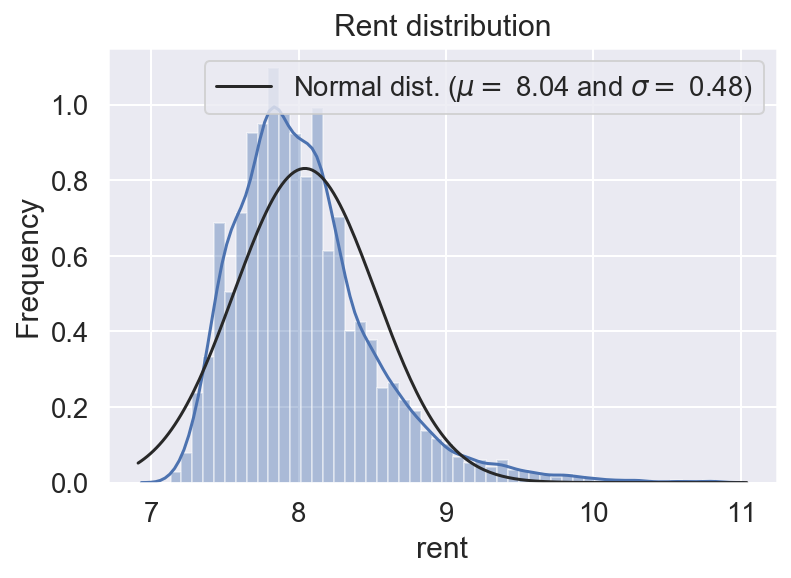

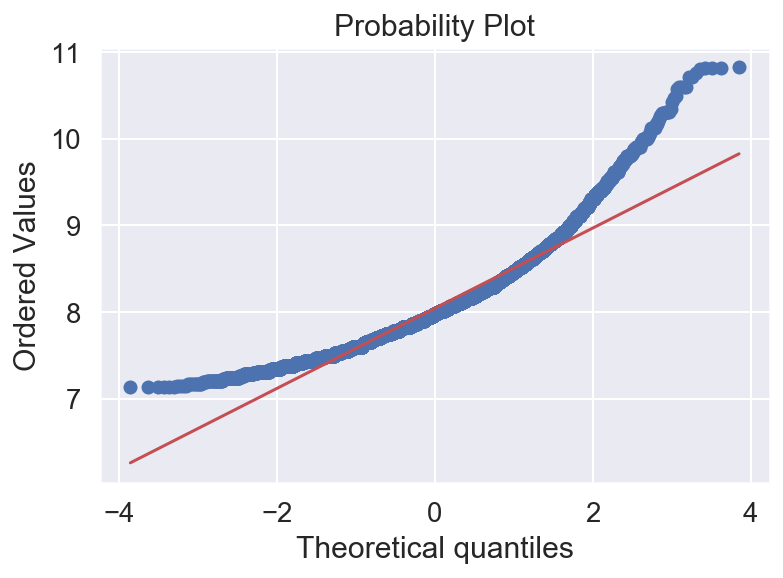

Skewness: 1.2656151840787009
Kurtosis: 2.8103451518059215


In [53]:
# We use the numpy fuction log1p which  applies log(1+x) to all elements of the column
train_df["rent"] = np.log1p(train_df["rent"])

#Check the new distribution 
sns.distplot(train_df['rent'] , fit=norm);

# Get the fitted parameters used by the function
(mu, sigma) = norm.fit(train_df['rent'])
print( f'\n mu = {mu:.2f} and sigma = {sigma:.2f}\n')
plt.legend([f'Normal dist. ($\mu=$ {mu:.2f} and $\sigma=$ {sigma:.2f})'],
            loc='best')
plt.ylabel('Frequency')
plt.title('Rent distribution')

fig = plt.figure()
res = stats.probplot(train_df['rent'], plot=plt)
plt.show()

print(f"Skewness: {train_df['rent'].skew()}")
print(f"Kurtosis: {train_df['rent'].kurt()}")

## Modeling

- First we will split `all_data` into the oringal train and test sizes

**NOTE**
1. the test set had *some* input in the imputations of missing values but I consider it minimal considering the size of the data set compared to the training set and...

2. most of the columns imputed are not in the final feature list

In [54]:
# split train and test sets

train = all_data_df[:ntrain_df]
test = all_data_df[ntrain_df:]

train.head()

,addr_unit,building_id,bedrooms,bathrooms,size_sqft,addr_street,addr_city,addr_zip,addr_lat,addr_lon,...,has_childrens_playroom,no_fee,neighborhood,borough,unit,floornumber,line,borough_encoded,addr_zip_encoded,neighborhood_encoded
0,#22A,551248,4,3.0,1300.0,645 OCEAN AVENUE,Brooklyn,11226,40.646982,-73.960065,...,0,1,Flatbush,Brooklyn,22A,6,B,3,69.0,54.0
1,#406,3373,0,1.0,475.0,93 WORTH STREET,New York,10013,40.716599,-74.004799,...,0,0,Tribeca,Manhattan,406,4,06,4,148.0,145.0
2,#18A,70747,3,3.0,1886.0,305 EAST 51 STREET,New York,10022,40.755402,-73.967598,...,0,0,Midtown East,Manhattan,18A,18,A,4,141.0,127.0
3,#23E,42076,1,1.0,827.0,70 WEST 37TH STREET,New York,10018,40.751301,-73.986298,...,0,1,Midtown South,Manhattan,23E,23,E,4,124.0,129.0
4,#3B,319156,3,1.0,1200.0,43 MAC DONOUGH STREET,Brooklyn,11216,40.681132,-73.944678,...,0,1,Bedford-Stuyvesant,Brooklyn,3B,3,B,3,98.0,96.0


In [55]:
test.head()

,addr_unit,building_id,bedrooms,bathrooms,size_sqft,addr_street,addr_city,addr_zip,addr_lat,addr_lon,...,has_childrens_playroom,no_fee,neighborhood,borough,unit,floornumber,line,borough_encoded,addr_zip_encoded,neighborhood_encoded
11974,#1B,18724,1,1.0,550.0,167 MOTT STREET,New York,10013,40.719799,-73.996399,...,0,1,Little Italy,Manhattan,1B,1,B,4,148.0,130.0
11975,#C4,403900,1,1.0,750.0,107 LINDEN STREET,Brooklyn,11221,40.693118,-73.920035,...,0,1,Bushwick,Brooklyn,C4,4,C,3,94.0,97.0
11976,#GARDEN,18175264,2,1.0,800.0,47 CARROLL STREET,Brooklyn,11231,40.683399,-74.003998,...,0,0,Columbia St Waterfront District,Brooklyn,GARDEN,6,A,3,112.0,123.0
11977,#2C,104863,2,2.0,1300.0,952 COLUMBUS AVENUE,New York,10025,40.799900,-73.962799,...,0,1,Upper West Side,Manhattan,2C,2,C,4,120.0,133.0
11978,#9,95125,2,1.0,750.0,424 EAST 116 STREET,New York,10029,40.795350,-73.934597,...,0,0,East Harlem,Manhattan,9,6,A,4,99.0,89.0


## Creating Models

We will use a linear regressor and a randomforestregressor as the main choices for this round.
We are selecting features based on those *most* correlated with 'rent' from previous analysis and those we encoded.


In [62]:
# linear model

features = ['bedrooms','size_sqft','bathrooms','has_washer_dryer','has_doorman','floornumber',
            'has_concierge','has_gym','borough_encoded','addr_zip_encoded',
            'neighborhood_encoded','has_elevator']

X_train = train[features]
X_test = test[features]

X_train = X_train.fillna(X_train.median(), axis=0)
X_test = X_test.fillna(X_test.median(), axis=0)

lr = LinearRegression()

lr.fit(X_train,target_train)

pred = lr.predict(X_test)

print(f'R2_Score:{lr.score(X_test,target_test)}')

print(f'mean_squared_error:{MSE(target_test,pred)}')


R2_Score:0.6383243842074016
mean_squared_error:2697074.6221327554


**Observations**

- We can see that our R2 score (how accurate our model is) is decent and the MSE is ok, although the test set had some input in imputation for certain features.
- We can see below the coefficient values for the feature variables and see the weights associated with them. Interestingly, bedrooms has a negative coeficient value.

In [ ]:
lr.coef_

### **Random Forest Regressor**

We will create a random forest regressor and see how it compares to the linear model

In [161]:
# random forest ensemble 

rf = RandomForestRegressor()

rf.fit(X_train,target_train)
pred_rf = rf.predict(X_test)

print(rf.score(X_test,target_test))

print(MSE(target_test,pred_rf))


0.7797230762013667
1642641.2925759729


- We can see that a the ensemble method performed substantially better than the linear regressor...
- Seems like this is our model of choice for now and we need to tune parameters

## **Hyperparameter Tuning**

- We need to tune the random forest regressor in order to see some more improvement in accuracy and MSE scores.

- We will begin by using a randomized search over a wide range of values to narrow down the best values to use in a grid search.

- We use this approach because grid searching is computationally expensive and we will limit the number of combinations we will search with.

In [ ]:
# # random search hyper parameter tuning for random forest regressor before using grid search

#using for gradient boosting regressor

from sklearn.model_selection import RandomizedSearchCV

# number of trees in forest
n_estimators = [int(x) for x in np.linspace(start = 10,stop = 50,num = 10)]

# maximum depth of each tree
max_depth = [int(x) for x in np.linspace(start=10,stop=110, num=11)]
max_depth.append(None)

# min number of samples required to split on a node
min_samples_split = [2,5,10]

# min number of samples per leaf before a split can occur
min_samples_leaf = [1,2,4]

# number of features to consider when splitting
max_features = ['auto','sqrt']

# if bootstrap sampling is used to train
#bootstrap = [True,False]

# learning rate of the mode
learning_rate = [0.001,0.01,0.1,0.2,0.3]  #added for gradient boosted regressor

# subsample
subsample = [0.6,0.8,1] ##using for gradient boosting regressor

# final parametr dictionary
randomf_grid = {'n_estimators':n_estimators,
               'max_depth':max_depth,
               'min_samples_split':min_samples_split,
               'min_samples_leaf':min_samples_leaf,
               'max_features':max_features,
               #'bootstrap':bootstrap,
                'learning_rate':learning_rate,
                'subsample':subsample
               }



In [ ]:
# #intialize estimator
# rfr = RandomForestRegressor()

# rf_search = RandomizedSearchCV(estimator = rfr,param_distributions = randomf_grid,
#                                n_iter=200,n_jobs = -1,cv=3,verbose=2,random_state=42)

# # fit model
# rf_search.fit(X_train,target_train)




**Results**

We see below the best params and a table of the estimators sorted by rank and their params
Using this table we will narrow the grid search params to only the best.

In [ ]:
# # best parameters of the best estimator

# rf_search.best_params_

In [ ]:
# # predict using the best estimator
# pred_rrf = rf_search.predict(X_test)



In [ ]:
# # the best score of any estimator
# rf_search.best_score_

In [ ]:
# # R2 score for the randomized search regressor

# rf_search.score(X_test,target_test)

In [ ]:
# # dataframe of best values

# rf_search_results = pd.DataFrame(rf_search.cv_results_).sort_values(by='rank_test_score')
# rf_search_results


In [ ]:
# # better view of parameters

# pd.set_option('display.max_colwidth', -1)
# rf_search_results['params'].head(10)

**Observations**

- The random search helped narrow down parameters to explore further
- The R2 error didnt improve much which is suggesting a ceiling to the improvemnt of the model
- In order to improve the model we may need to impute using better values/intuitions and testing with other features.

In [ ]:
# # grid search to find the optimal hyper parameterss

#using for gradientboosting regressor

from sklearn.model_selection import GridSearchCV

param_grid = {'n_estimators':[20,30,40,50],
               'max_depth':[30,50,60,80,90],
               'min_samples_split':[5,10], #changed for gradient boosting reg
               'min_samples_leaf':[2,4],
               'max_features':['sqrt'], #changed for gradient boosting reg
               #'bootstrap':[False]
              'learning_rate':[0.1], ##used for gradient boosting reg
              'subsample':[0.6,0.8,1] #used for gradient boosting regressor
               }

# rfr_gs = RandomForestRegressor()

# grid_search = GridSearchCV(estimator = rfr_gs, param_grid = param_grid, 
#                           cv = 3, n_jobs = -1, verbose = 2)

# grid_search.fit(X_train,target_train)

In [ ]:
# grid_search.best_params_

In [ ]:
# gs_results = pd.DataFrame(grid_search.cv_results_).sort_values(by='mean_test_score',ascending=False)
# gs_results.head()

In [ ]:
# best_est = grid_search.best_estimator_


# best_pred = best_est.predict(X_test)

# MSE(target_test,best_pred)

In [ ]:
# # transform target variable for better predictions

# from sklearn.compose import TransformedTargetRegressor

# rf_trans = TransformedTargetRegressor(regressor = best_est,func = np.log1p, inverse_func = np.expm1)
# rf_trans.fit(X_train,target_train)
# rf_trans_pred = rf_trans.predict(X_test)

# MSE(target_test,rf_trans_pred)

In [ ]:
# rf_trans.score(X_test,target_test)

**Observations**

- Notice the the grid search best estimator with the optimal parameters has a better R2 value and MSE score
- The estimator using the transformed target is not as good as the untransformed target. 
- Our model seems to perform okay currently and could be improved on but further development needs to be done.

In [ ]:
#***GRADIENTBOOSTINGREGRESSOR***

gbr = GradientBoostingRegressor()
gbr.fit(X_train,target_train)
gbr_pred = gbr.predict(X_test)
MSE(target_test,gbr_pred)

In [ ]:
## random search cv

random_gbr = RandomizedSearchCV(estimator = gbr,param_distributions = randomf_grid,
                   n_iter=200,n_jobs = -1,cv=3,verbose=2,random_state=42)

random_gbr.fit(X_train,target_train)


In [ ]:
random_gbr.best_params_

In [ ]:
gbr_best = random_gbr.best_estimator_

MSE(target_test,gbr_best.predict(X_test))

In [ ]:
random_gbr_results = pd.DataFrame(random_gbr.cv_results_).sort_values(by='rank_test_score')
random_gbr_results

In [ ]:

pd.set_option('display.max_colwidth', -1)
random_gbr_results['params'].head(10)

In [ ]:
# grid search gbr 

grid_search_gbr = GridSearchCV(estimator = gbr, param_grid = param_grid, 
                           cv = 3, n_jobs = -1, verbose = 2)

grid_search_gbr.fit(X_train,target_train)

In [ ]:
MSE(target_test,grid_search_gbr.best_estimator_.predict(X_test))

In [ ]:
# ***xtreme gradient boosting regressor***

xgbr = xgb.XGBRegressor()

xgbr.fit(X_train,target_train)
xgbr_pred = xgbr.predict(X_test)
MSE(target_test,xgbr_pred)

## Predicting and creating Submission file

Lets import the submission dataframe and observe it

In [ ]:
# import Submission data set


submission_df = pd.read_csv('Datasets/SE_rents2018_test2.csv')

submission_df.head()

We will again drop unnecessary columns and apply the same imputations as the training set

**Note**

- Imputations will solely rely on values attained from itself. I.E the medium will only consist of values from submission set
- This will ensure that there is minimal data leakage and the model has semi unbiased predictions.

In [ ]:
# drop unecessary columns 
submission_df.drop(["rent","created_at",'description','bin'],axis=1,inplace=True)

In [ ]:
# size_sqft = 0 to nan

submission_df.loc[submission_df['size_sqft']==0,'size_sqft'] = np.nan

In [ ]:
# bathrooms = 0 to nan
submission_df.loc[submission_df['bathrooms']==0,'bathrooms'] = np.nan

In [ ]:
# bedrooms = 0 to nan
submission_df.loc[submission_df['bedrooms']==0,'bedrooms'] = np.nan

In [ ]:
# Find NaN Ratio of Dataset

submission_na = (submission_df.isnull().sum() / len(submission_df)) * 100
submission_na = submission_na.drop(submission_na[submission_na == 0].index).sort_values(ascending=False)[:30]
missing_data = pd.DataFrame({'Missing Ratio':submission_na})
missing_data

In [ ]:
# Percent missing data by feature

f, ax = plt.subplots(figsize=(15, 12))
plt.xticks(rotation='90')
sns.barplot(x=submission_na.index, y=submission_na)
plt.xlabel('Features', fontsize=15)
plt.ylabel('Percent of missing values', fontsize=15)
plt.title('Percent missing data by feature', fontsize=15)

In [ ]:
# impute missing line values using zipcode and most frequent line in that area
submission_df['line'] = submission_df.groupby('addr_zip')['line'].transform(lambda x: x.fillna(stats.mode(x).mode[0]))

#impute missing bedroom values with 1 as they were all 0 before 
submission_df['bedrooms'].fillna(1,inplace=True)

#impute floornumber missing values with mean floornumber
submission_df['floornumber'].fillna(submission_df['floornumber'].mean(),inplace=True)
submission_df['floornumber'] = submission_df['floornumber'].round(0).astype(int)

#impute size_sqft missing values with mean size of # of bedrooms
submission_df['size_sqft'] = submission_df.groupby('bedrooms')['size_sqft'].transform(lambda x: x.fillna(x.mean()))

#impute year_built missing values with year_built mean of addr_zipcode
submission_df['year_built'] = submission_df.groupby('addr_zip')['year_built'].transform(lambda x: x.fillna(x.mean()))

#impute min_to_subway missing values with mean of addr_zipcode
submission_df['min_to_subway'] = submission_df.groupby('addr_zip')['min_to_subway'].transform(lambda x: x.fillna(x.mean()))

#impute unit missing values with column mean
submission_df['unit'].fillna(submission_df['unit'].mode()[0],inplace=True)

#impute addr_unit missing values with column mean
submission_df['addr_unit'].fillna(submission_df['addr_unit'].mode()[0],inplace=True)

#impute bathrooms missing values with 1 as they were 0 before
submission_df['bathrooms'].fillna(1,inplace=True)

#impute neighborhood missing values with addr_zip mode
submission_df['neighborhood'] = submission_df.groupby('addr_zip')['neighborhood'].transform(lambda x: x.fillna(stats.mode(x).mode[0]))



In [ ]:
#Check if there are any missing values left

submission_na = (submission_df.isnull().sum() / len(submission_df)) * 100
submission_na = submission_na.drop(submission_na[submission_na == 0].index).sort_values(ascending=False)
missing_data = pd.DataFrame({'Missing Ratio' :all_data_na})

We will again seek to encode certain features to make sure that our model can perform optimally. 

We will encode the borough in the same manner as the training set as there are no new entries and, since we dont have rent values, we cant really alter the encoding

In [ ]:
# feature transoforming borough

print(submission_df['borough'].describe())
print(f"\n{submission_df['borough'].value_counts()}")
borough_rank_dic = {"Staten Island": 0,
                   "Bronx":1,
                   "Queens":2,
                   "Brooklyn":3,
                   "Manhattan":4}

submission_df['borough_encoded'] = submission_df['borough'].map(borough_rank_dic)




The same thing will be done with addr_zip in that the values will be imputed using encoded dictionary from the training set.

**Note**

We will have to check for encoded values that are NaN, caused by new zipcodes that arent in our dictionary...

To solve this issue we will impute those values using the avg encoded value for the listing, grouped by borough.
This will provide the avg encoded value for a listing in a borough.

In [ ]:
# feature transforming addr zip

print(submission_df['addr_zip'].describe())

submission_df['addr_zip_encoded'] = submission_df['addr_zip'].map(addr_zip_rank_dic)



In [ ]:
# imputing unknown values in addr_zip_encoded

bor_encoded_avg = submission_df.groupby('borough')['addr_zip_encoded'].mean().round(0).to_dict()

def impute_unknown(rental_id):
    submission_df.loc[submission_df['rental_id'] == rental_id,'addr_zip_encoded'] = bor_encoded_avg[submission_df.loc[submission_df['rental_id'] == rental_id,'borough'].values[0]] 

submission_df[submission_df['addr_zip_encoded'].isnull()]['rental_id'].transform(lambda x: impute_unknown(x))

submission_df[submission_df['addr_zip_encoded'].isnull()]



Finally feature encoding neighborhood will be done similarly to addr_zip using value dictionary from training set..

*Again* note that unknown neighborhoods will get an encoded value that is the avg from neighborhoods in a specific borough

In [ ]:
# feature transforming neighborhoods

print(submission_df['neighborhood'].describe())

submission_df['neighborhood_encoded'] = submission_df['neighborhood'].map(neighborhood_rank_dic)

submission_df[submission_df['neighborhood_encoded'].isnull()]

In [ ]:
# impute unknown neighborhoods

neigh_encoded_avg = submission_df.groupby('borough')['neighborhood_encoded'].mean().round(0).to_dict()

def impute_un(rental_id):
    submission_df.loc[submission_df['rental_id'] == rental_id,'neighborhood_encoded'] = neigh_encoded_avg[submission_df.loc[submission_df['rental_id'] == rental_id,'borough'].values[0]] 
    
submission_df[submission_df['neighborhood_encoded'].isnull()]['rental_id'].transform(lambda x: impute_un(x))

submission_df[submission_df['neighborhood_encoded'].isnull()]


## Predicting using our Model

we will retrain our best_estimator using the train data and test1 data so that the model has more data to train on...

we will combine the test target and train target into a master target for model fitting.


In [ ]:
feature_master =all_data_df[features].fillna(all_data_df[features].median(), axis=0)
target_master = np.concatenate((target_train,target_test))

##best_est.fit(feature_master,target_master)  ***inital random forest regressor***

##submission_df['predictions']= best_est.predict(submission_df[features])  ***delete later***

## Visualizing 

Looking at the submission data's predictions against our feature variables to see if the predictions *"make sense"* in that there arent any wierd outliers and we could look at the size,bedroom,bathroom, borough, and neighborhood and feel like the values make sense.

In [ ]:
#submission_df[features+['predictions']]

## Exporting File

Lets export our predictions to a csv file for submitting...

we will reindex the data so that rental_id is the index

In [ ]:
#submission_df.set_index('rental_id')[['predictions']].to_csv('prediction_submission2.csv', header=True)